In [1]:
import numpy as np
import pandas as pd

from hyperopt import hp

In [11]:
from collections import deque, defaultdict
from time import time

In [41]:
N = 3
last = 10  #5 min

class Hi:
    d = dict()
    s = set()
    
    def Add(self, userID, time):
        if userID in self.d:
            self.d[userID].append(time)
            if userID not in self.s:
                if len(self.d[userID]) == N:
                    self.s.add(userID)
        else:
            self.d[userID] = deque([time], N)
    
    def Get(self):
        now = time() - last
        print(now)
        print(self.d)
        print()
        res = 0
        for userID in self.s:
            a = self.d[userID].popleft()
            self.d[userID].appendleft(a)
            if a > now:
                res += 1
                
        return res

In [42]:
hi = Hi()
hi.Add(1, time())
hi.Add(1, time())
hi.Add(1, time())
hi.Add(1, time())

In [43]:
hi.Add(5, time())
hi.Add(5, time())
hi.Add(5, time())
hi.Get()

1637715026.7030137
{1: deque([1637715023.2598464, 1637715023.2599282, 1637715023.2599986], maxlen=3), 5: deque([1637715036.7027733, 1637715036.702858, 1637715036.7029445], maxlen=3)}



1

In [2]:
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import joblib
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

import lightgbm as lgb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

from time import time

In [3]:
df = pd.read_pickle('./data/rename_x1_class.pkl_gz', compression='gzip')
df

,nrow,objID,ra,dec,zspec,zspec_conf,zspec_source,class,subclass,class1,...,zoo_best-x1_ci1a_90_Lx_err,zoo_best-x1_ci1b_90_Lx_err,zoo_best-x1_ci1a_95,zoo_best-x1_ci1b_95,zoo_best-x1_ci1a_95_DL_cm,zoo_best-x1_ci1b_95_DL_cm,zoo_best-x1_ci1a_95_Lx,zoo_best-x1_ci1b_95_Lx,zoo_best-x1_ci1a_95_Lx_err,zoo_best-x1_ci1b_95_Lx_err
0,765558,166771828504836546,182.850396,48.979910,0.046132,-999.0,SDSS,3,STARFORMING,,...,NaN,NaN,-0.023962,0.026538,NaN,NaN,NaN,NaN,NaN,NaN
1,295976,140921926169192374,192.616971,27.434890,0.021385,-999.0,SDSS,3,BROADLINE,,...,NaN,NaN,-0.015042,0.014692,NaN,NaN,NaN,NaN,NaN,NaN
5,267711,153541551169831903,155.117013,37.951053,0.046178,-999.0,SDSS,3,N/A,,...,NaN,NaN,-0.023886,0.025979,NaN,NaN,NaN,NaN,NaN,NaN
6,94182,120741855100415434,185.510020,10.620819,0.025434,-999.0,SDSS,3,STARFORMING,,...,NaN,NaN,-0.017423,0.074669,NaN,NaN,NaN,NaN,NaN,NaN
11,476230,114671598619635888,159.861973,5.562852,0.028537,-999.0,SDSS,3,STARFORMING,,...,NaN,NaN,-0.027526,0.020971,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60414,960359,1237668503831839169,252.083230,50.783279,NaN,NaN,NaN,1,NaN,NaN,...,NaN,NaN,-0.451445,0.228902,NaN,NaN,NaN,NaN,NaN,NaN
60415,960360,1237665583790752642,252.201060,50.891273,NaN,NaN,NaN,1,NaN,NaN,...,NaN,NaN,-0.212508,2.934748,NaN,NaN,NaN,NaN,NaN,NaN
60416,960361,1237665584327361688,252.358160,51.708907,NaN,NaN,NaN,1,NaN,NaN,...,NaN,NaN,-0.855885,1.92245,NaN,NaN,NaN,NaN,NaN,NaN
60417,960362,1237665584327164382,252.128200,52.155919,NaN,NaN,NaN,1,NaN,NaN,...,NaN,NaN,-0.246795,2.79586,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
features_path = '../../models_before_aggregation_j/features.pkl'
column = 'J'
j_features = ['J']
features = pd.read_pickle(features_path) + j_features

In [5]:
for i in df.columns:
    print(i)

nrow
objID
ra
dec
zspec
zspec_conf
zspec_source
class
subclass
class1
class2
origin
Fx
in_XXLN
in_S82X
in_LH
is_12-SDSSunWISE
is_X
u
g
r
i
z
Lw1
Lw2
uM
gM
rM
iM
zM
ra_sdssdr16
dec_sdssdr16
distance
ra_dr16
dec_dr16
objID_sdssdr16
mjd
b
l
extinction_u
extinction_g
extinction_r
extinction_i
extinction_z
psfMag_u
psfMag_g
psfMag_r
psfMag_i
psfMag_z
cModelMag_u
cModelMag_g
cModelMag_r
cModelMag_i
cModelMag_z
psfFlux_u
psfFluxIvar_u
psfFlux_g
psfFluxIvar_g
psfFlux_r
psfFluxIvar_r
psfFlux_i
psfFluxIvar_i
psfFlux_z
psfFluxIvar_z
cModelFlux_u
cModelFluxIvar_u
cModelFlux_g
cModelFluxIvar_g
cModelFlux_r
cModelFluxIvar_r
cModelFlux_i
cModelFluxIvar_i
cModelFlux_z
cModelFluxIvar_z
w1_nanomaggies
w1_nanomaggies_ivar
w2_nanomaggies
w2_nanomaggies_ivar
ra_psdr2
dec_psdr2
distance_psdr2
objID_psdr2
raStack
decStack
raStackErr
decStackErr
objInfoFlag
qualityFlag
nDetections
primaryDetection
bestDetection
gKronFluxErr_min_error
gKronFlux_min_error
rKronFluxErr_min_error
rKronFlux_min_error
iKronFluxErr_

Будем смотреть на слкдующие признаки:

In [6]:
feat = """
ps_gKronFlux
ps_gKronFluxErr
ps_rKronFlux
ps_rKronFluxErr
ps_iKronFlux
ps_iKronFluxErr
ps_zKronFlux
ps_zKronFluxErr
ps_yKronFlux
ps_yKronFluxErr
ps_gPSFFlux
ps_gPSFFluxErr
ps_rPSFFlux
ps_rPSFFluxErr
ps_iPSFFlux
ps_iPSFFluxErr
ps_zPSFFlux
ps_zPSFFluxErr
ps_yPSFFlux
ps_yPSFFluxErr
""".split('\n')[1:-1]

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls

%matplotlib inline

In [42]:
p = df['ebv'].dropna()
np.min(np.log10(p)), np.max(np.log10(p))

(-2.6345671590836655, -0.29325251562371346)

In [12]:
def plotik(p, x, y):
    plt.title(x + ' and ' + y)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.xlim([-0.01, 0.04])
    plt.scatter(p[x],p[y], c='r')
    plt.show()

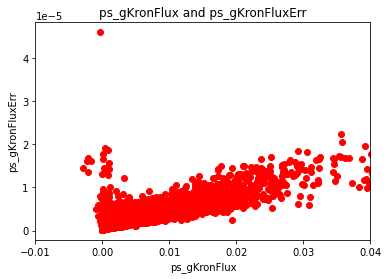

In [85]:
plotik(df, feat[0], feat[1])

Видим практически линейную зависимость. Ее можно предсказать с помощью линейных моделей или ближайших соседей

In [62]:
def plotik_ax(p, x, y, ax, color='r'):
    ax.set_title(x + ' and ' + y)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_xlim([-0.01, 0.07])
    ax.set_ylim([-0.1, 7])
    ax.scatter(p.loc[:, [x]], p.loc[:, [y]] / 0.00001, c=color, alpha=0.3)
    return ax

In [182]:
len(feat)

20

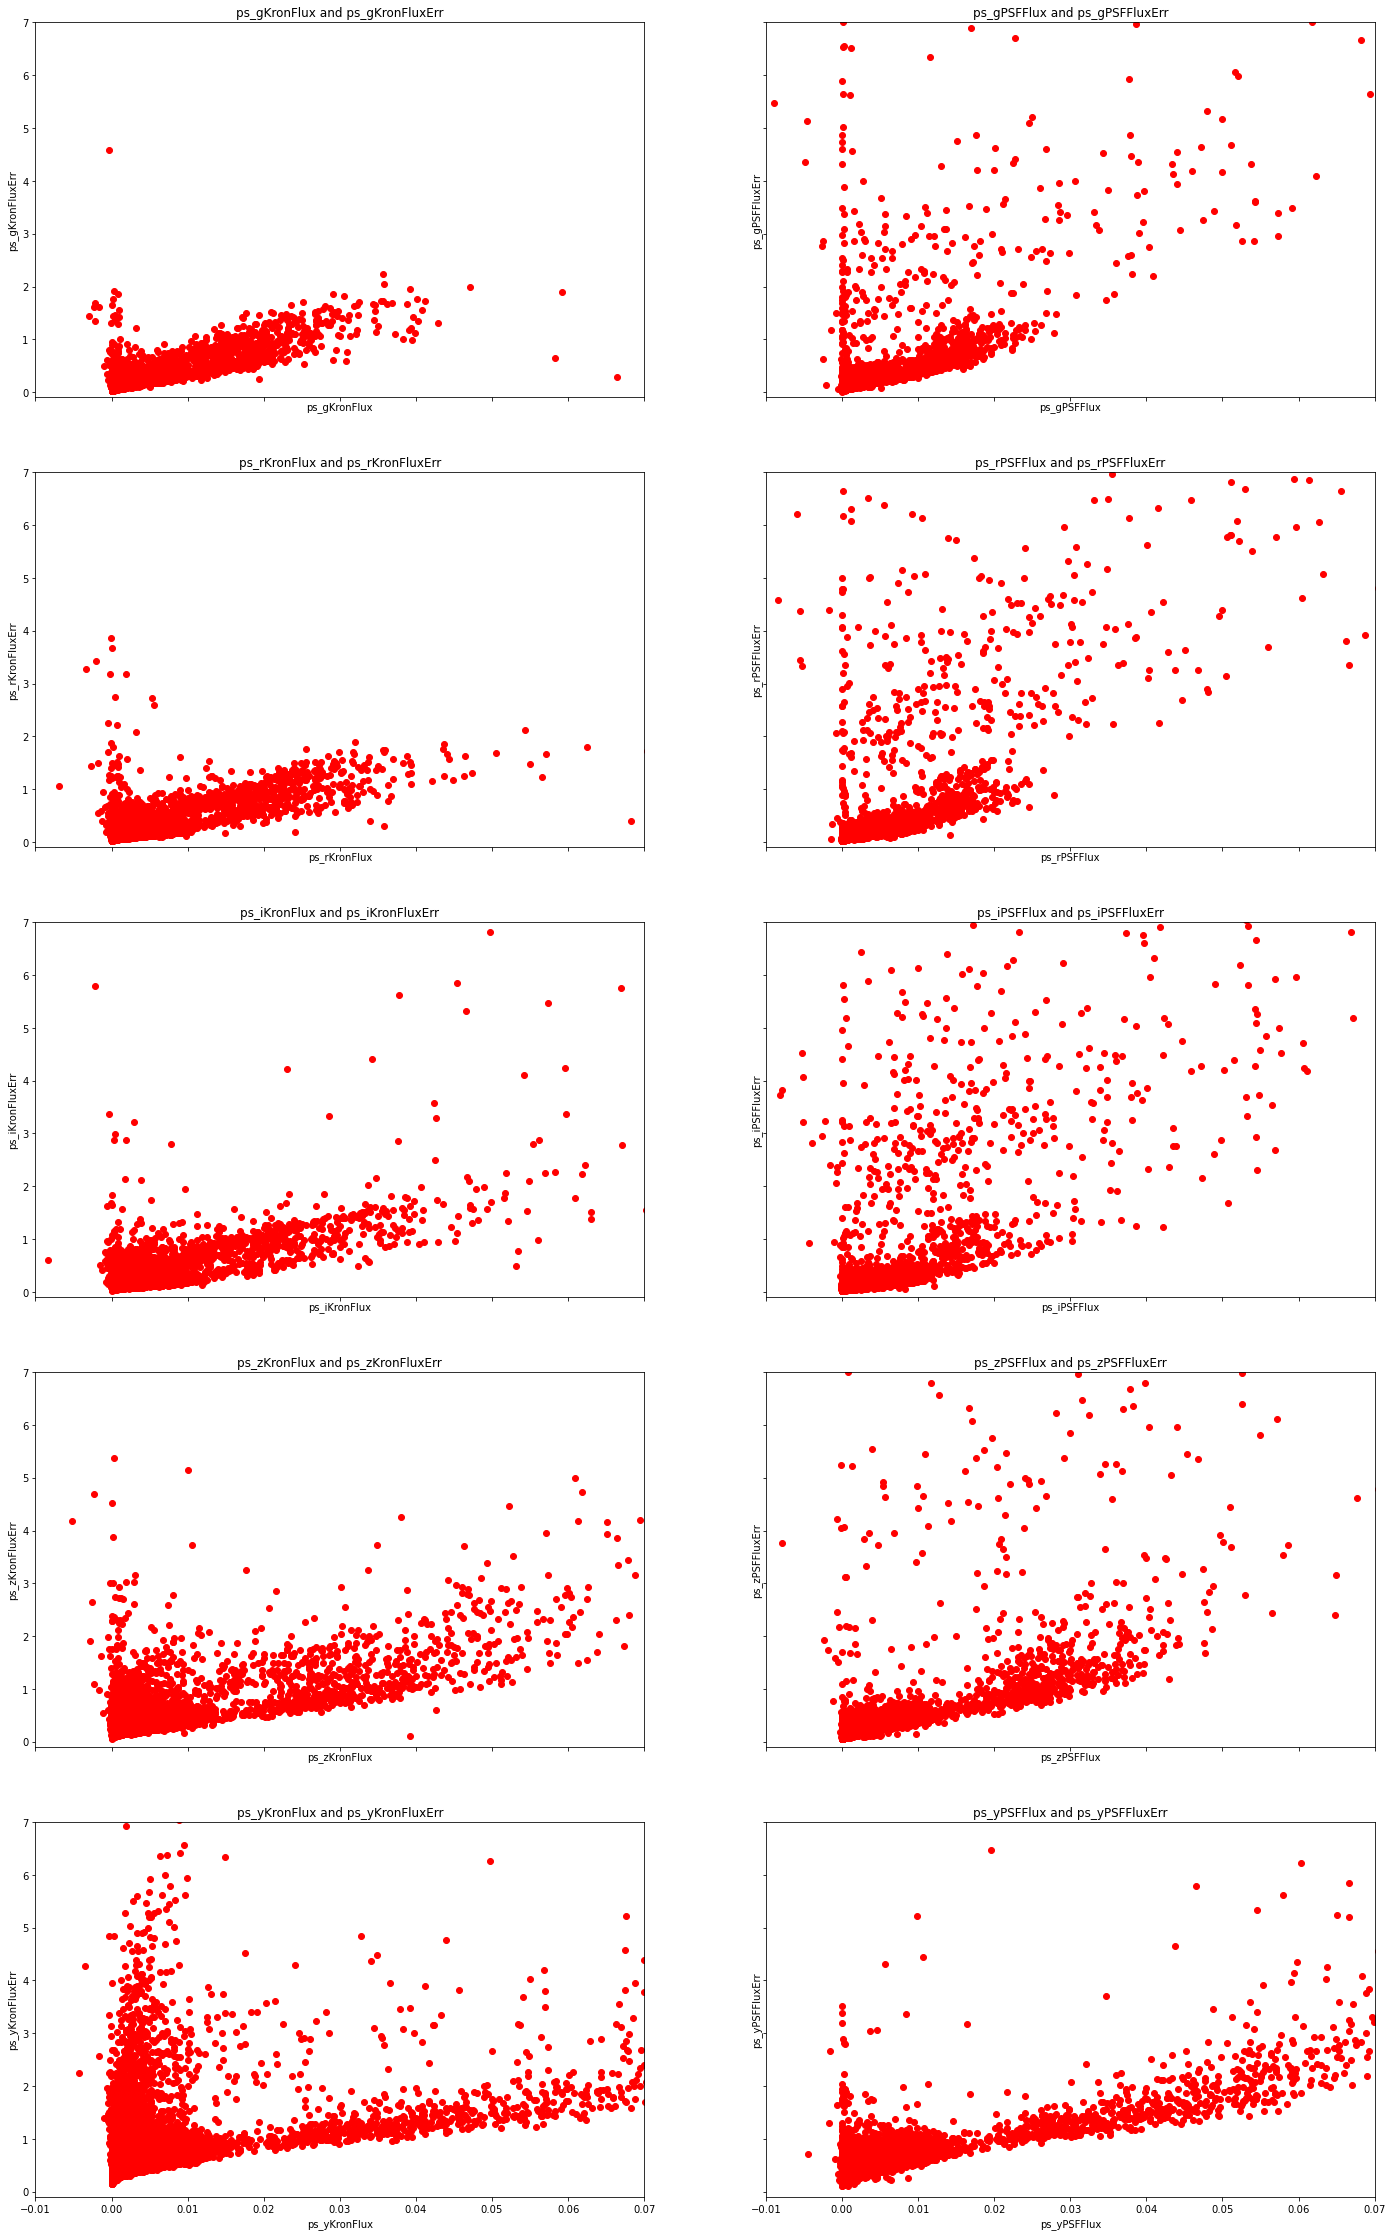

In [164]:
f, axes = plt.subplots(nrows = 5, ncols=2, figsize=(24, 40), sharex=True, sharey = True)
for i in range(len(feat) // 2):
    ax = axes[i % 5][i // 5]
    plotik_ax(df, feat[i*2], feat[i*2 + 1], ax)

In [127]:
from sklearn.linear_model import LinearRegression
df1 = df[feat[:2]].dropna()
X = df1[[feat[0]]]
y = df1[[feat[1]]]
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.08882231262606133

In [128]:
reg.score(X, y)

0.08882231262606133

In [129]:
reg.predict(X)

array([[7.07974121e-07],
       [7.06454279e-07],
       [7.05561870e-07],
       ...,
       [7.05646040e-07],
       [7.06157445e-07],
       [7.05552395e-07]])

In [130]:
reg.intercept_

array([7.05355981e-07])

In [9]:
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor

В данном примере используем среднее из 5 ближайших соседей 

Как вариант, можно заменить это предсказание в виде: 
 * брать лучшее 
 * разыгрывания в бине ближайших соседей - брать случайное 
 
 Без учета самого себя

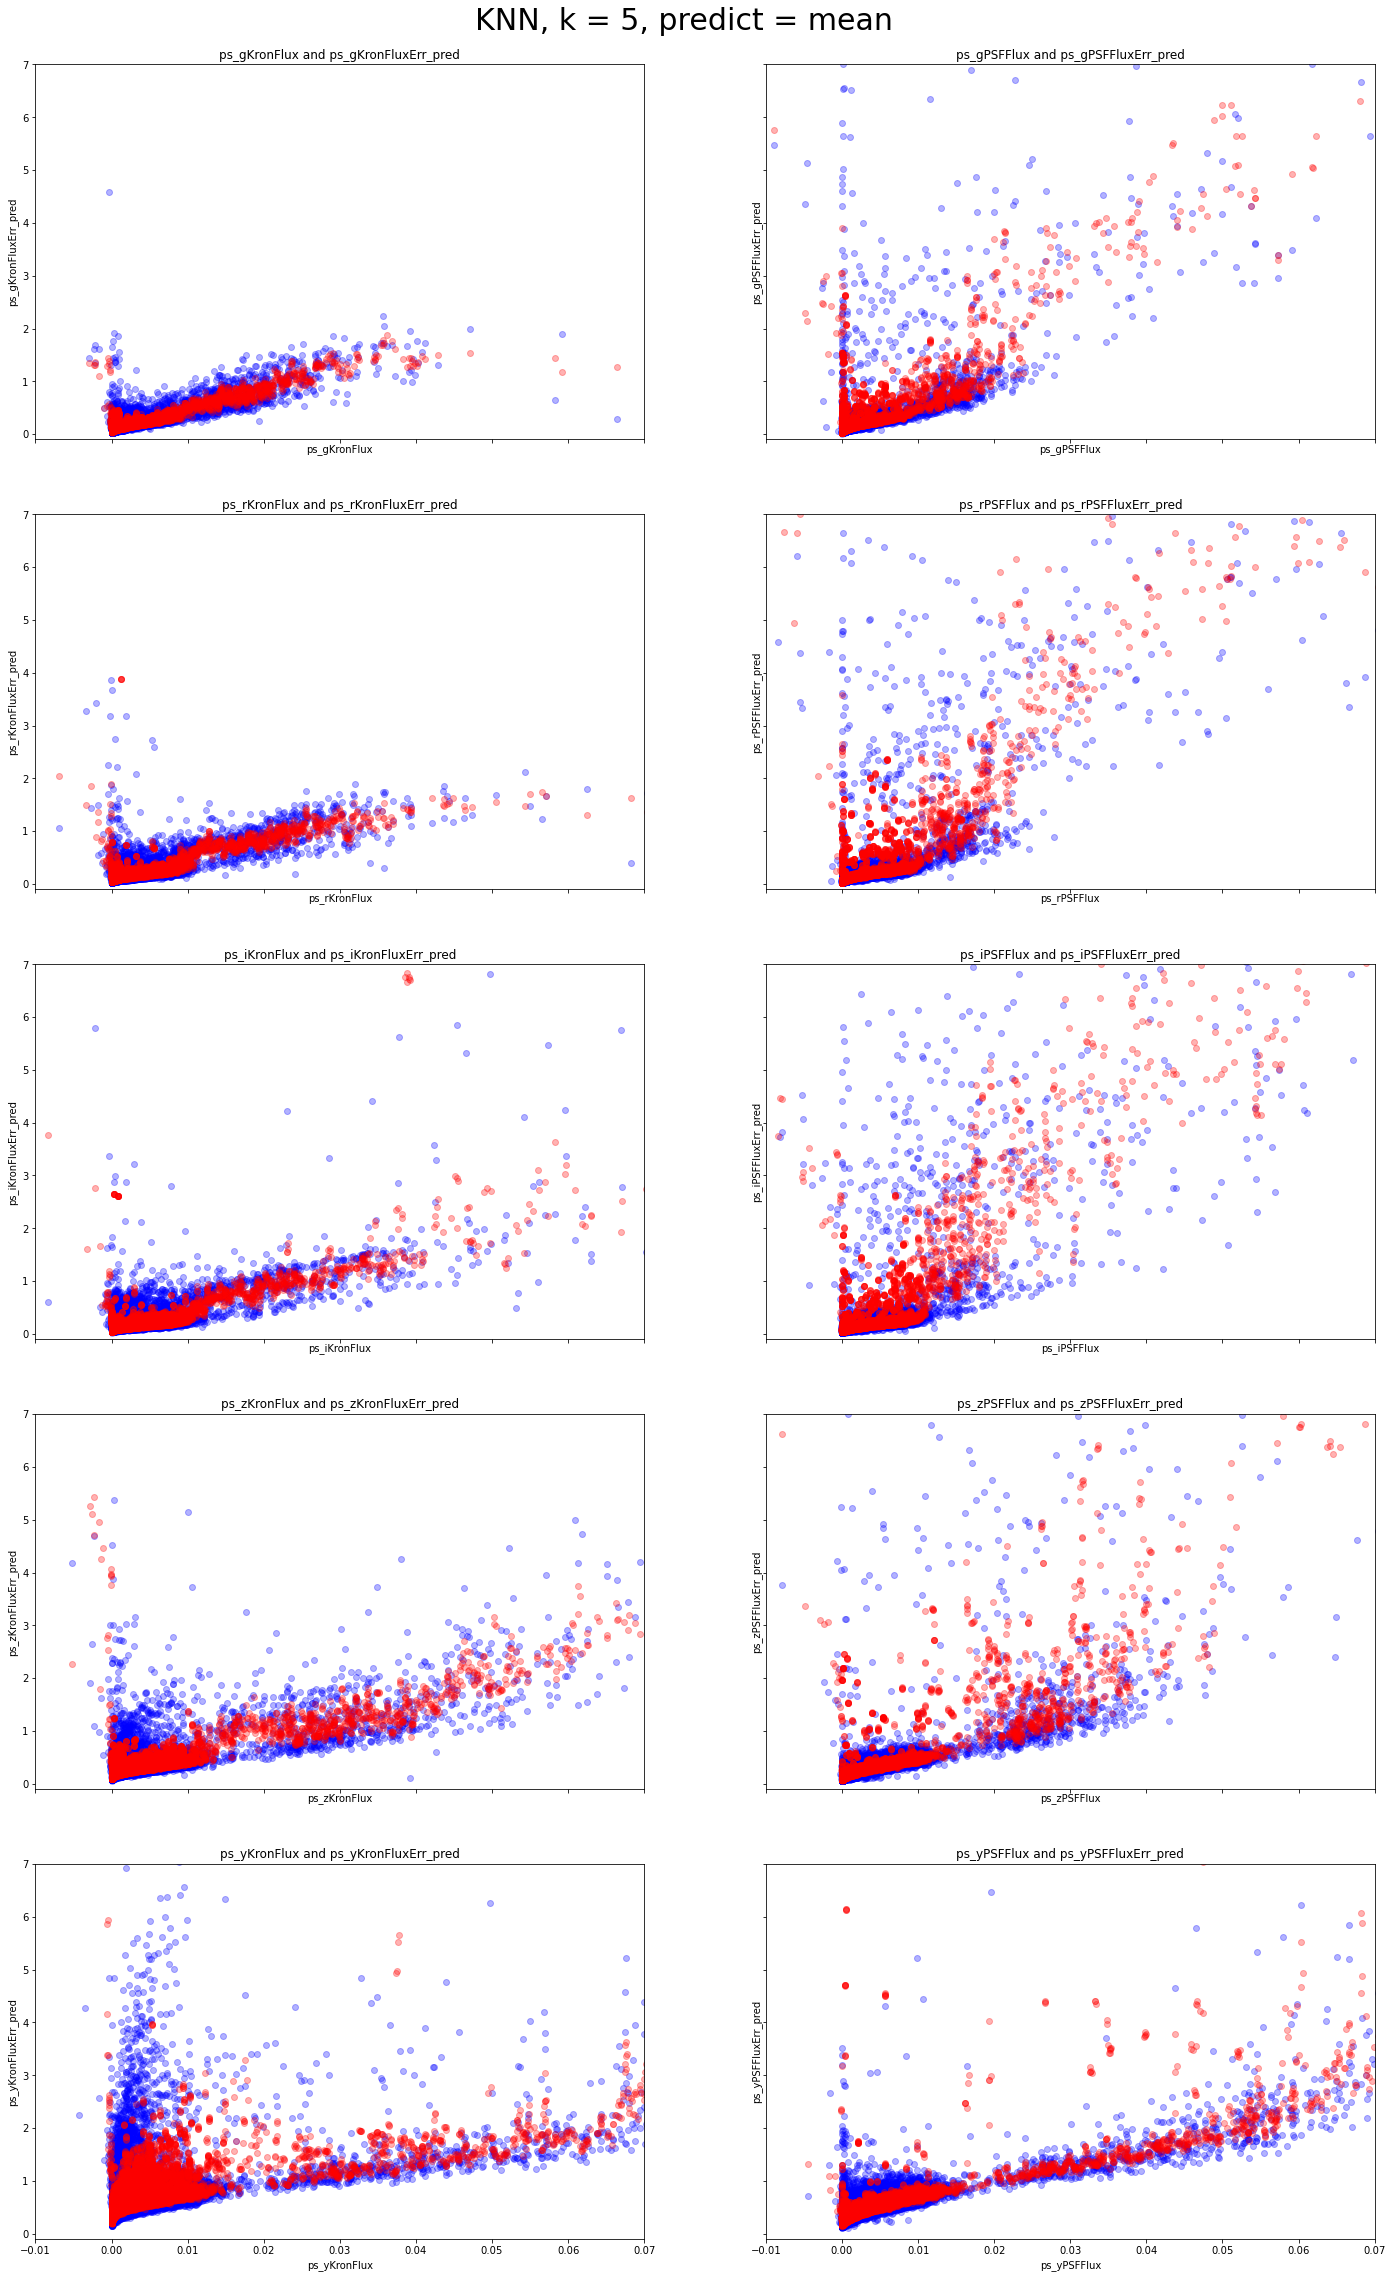

In [236]:
f, axes = plt.subplots(nrows = 5, ncols=2, figsize=(24, 40), sharex=True, sharey = True)
n_neighbors = 6
f.suptitle(f'KNN, k = {n_neighbors - 1}, predict = mean', y=0.9, fontsize=30)
for i in range(len(feat) // 2):
#     print(i)
    ax = axes[i % 5][i // 5]
    df1 = df[feat[i * 2 : i * 2 + 2]].dropna()
    X = df1[[feat[i * 2]]].values
    y = df1[[feat[i * 2 + 1]]].values
    reg = KNeighborsRegressor().fit(X, y)
    knb = reg.kneighbors(X, n_neighbors=n_neighbors, return_distance=False)
    pred = []
#     print(X.shape)
    for j, x in enumerate(X):
        pred.append(np.mean(y[knb[j][knb[j] != j]]))
#     print(pred[:10])
    df1[feat[i * 2 + 1] + '_pred'] = pred
    plotik_ax(df, feat[i*2], feat[i*2 + 1], ax, color='b')    
    plotik_ax(df1, feat[i * 2], feat[i * 2 + 1] + '_pred', ax, color='r')

Что будет, если возьмеи конкретное ближайшее значение?

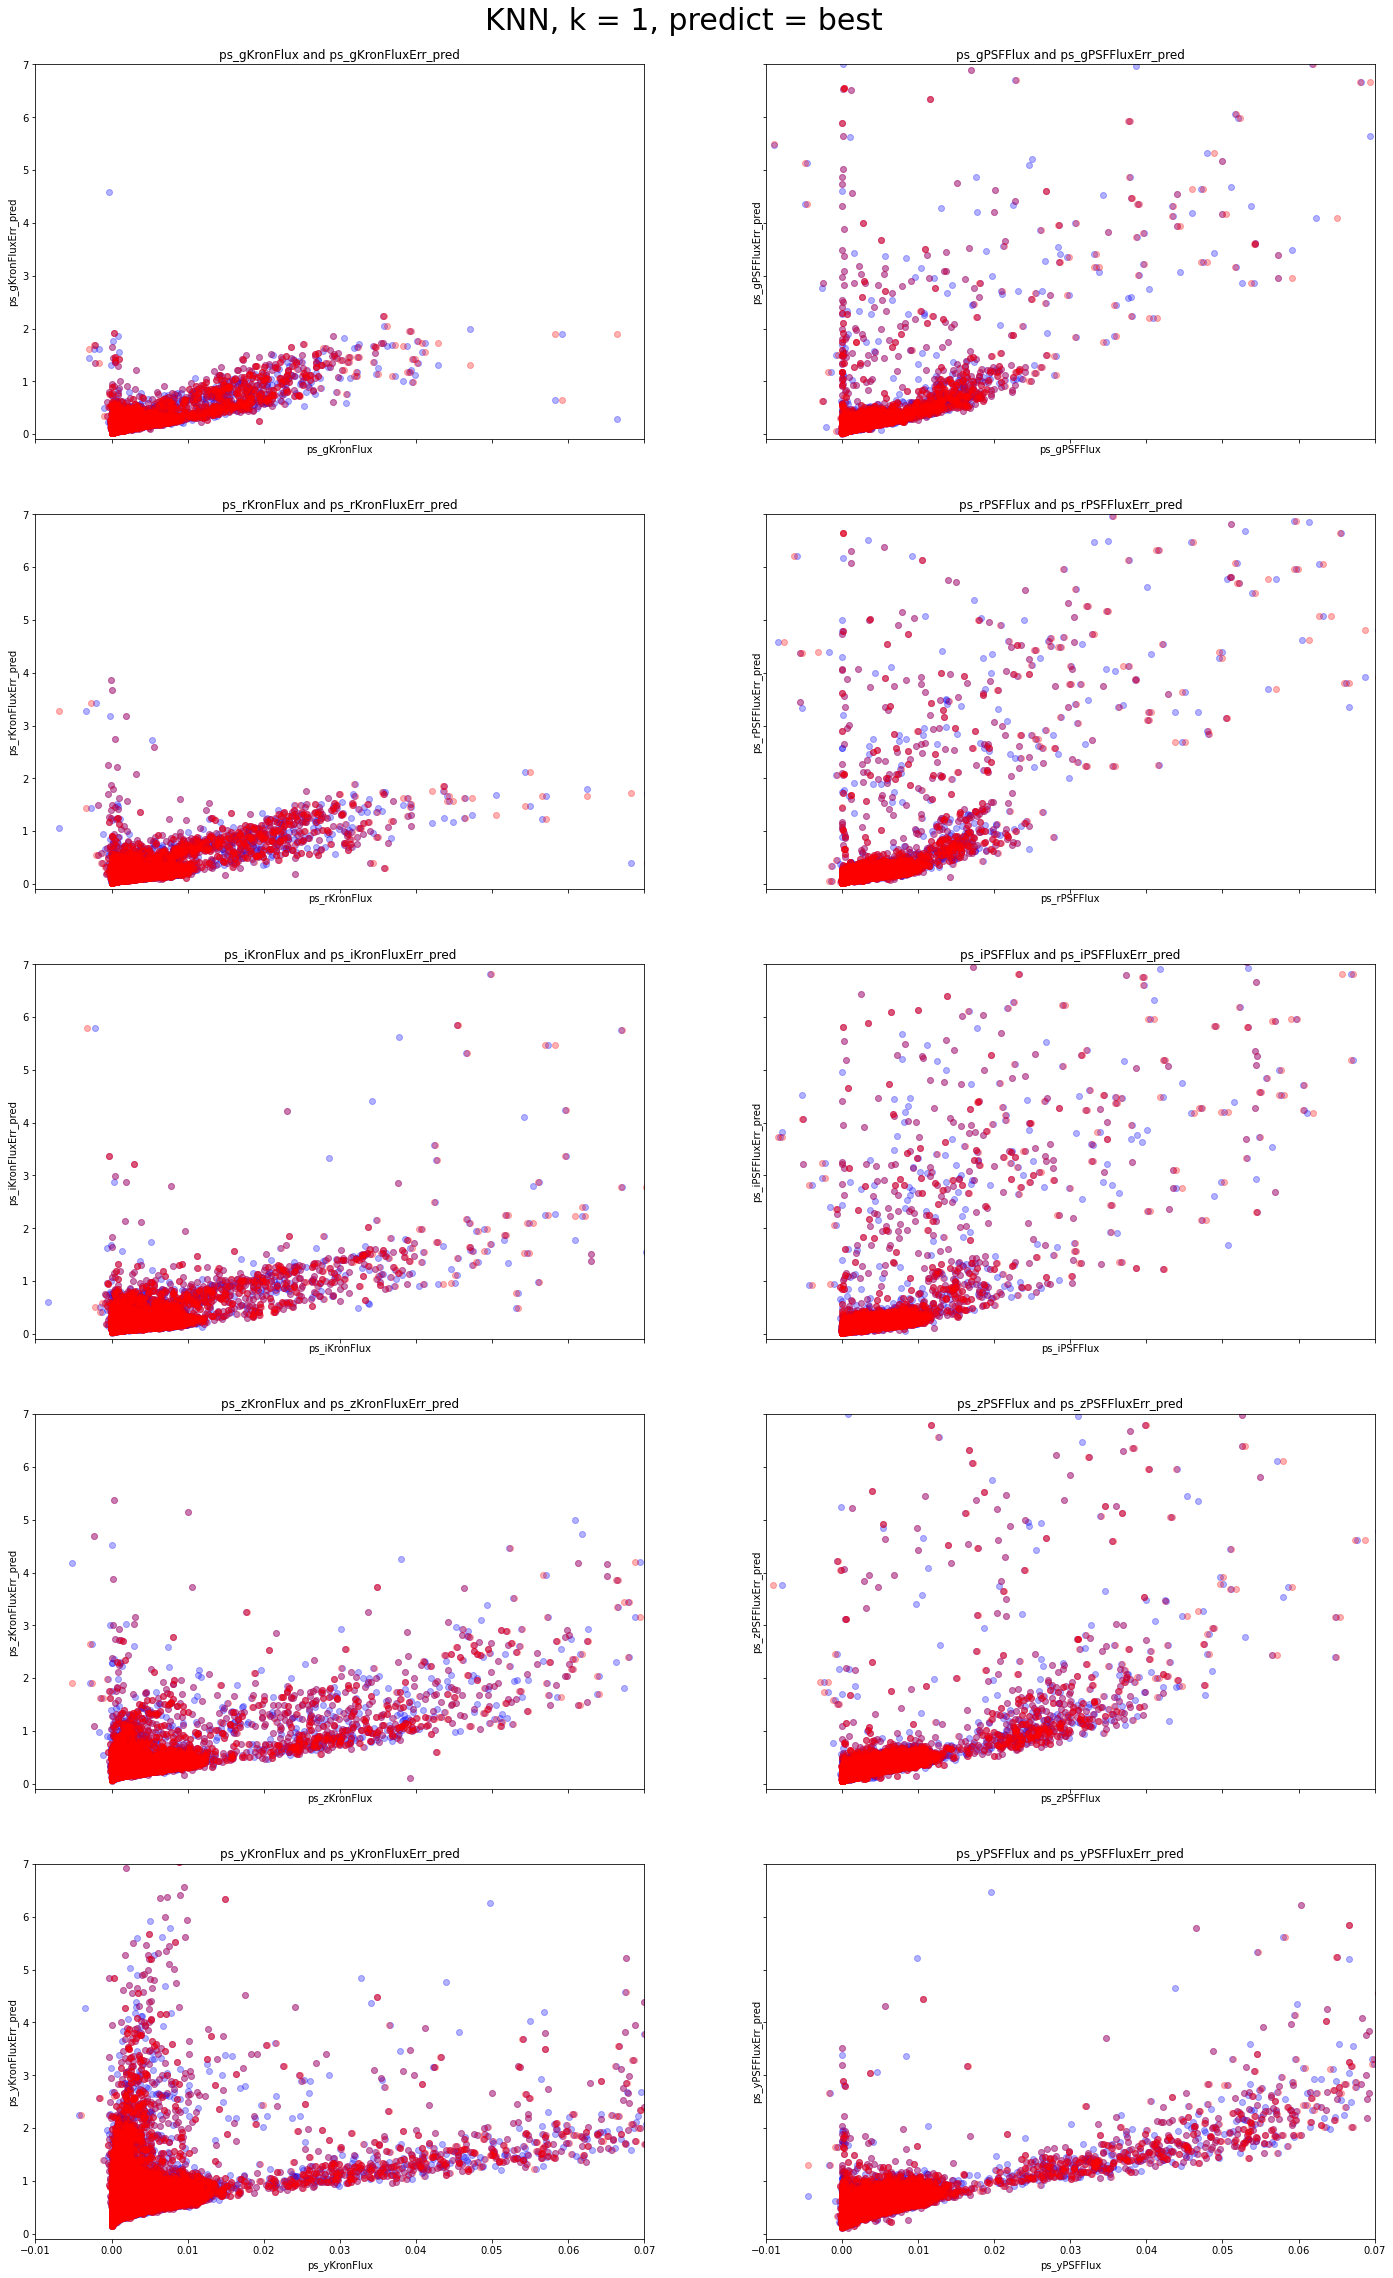

In [237]:
f, axes = plt.subplots(nrows = 5, ncols=2, figsize=(24, 40), sharex=True, sharey = True)
n_neighbors = 2
f.suptitle(f'KNN, k = {n_neighbors - 1}, predict = best', y=0.9, fontsize=30)
for i in range(len(feat) // 2):
#     print(i)
    ax = axes[i % 5][i // 5]
    df1 = df[feat[i * 2 : i * 2 + 2]].dropna()
    X = df1[[feat[i * 2]]].values
    y = df1[[feat[i * 2 + 1]]].values
    reg = KNeighborsRegressor().fit(X, y)
    knb = reg.kneighbors(X, n_neighbors=n_neighbors, return_distance=False)
    pred = []
#     print(X.shape)
    for j, x in enumerate(X):
        pred.append(np.mean(y[knb[j][knb[j] != j]]))
#     print(pred[:10])
    df1[feat[i * 2 + 1] + '_pred'] = pred
    plotik_ax(df, feat[i*2], feat[i*2 + 1], ax, color='b')    
    plotik_ax(df1, feat[i * 2], feat[i * 2 + 1] + '_pred', ax, color='r')

KeyboardInterrupt: 

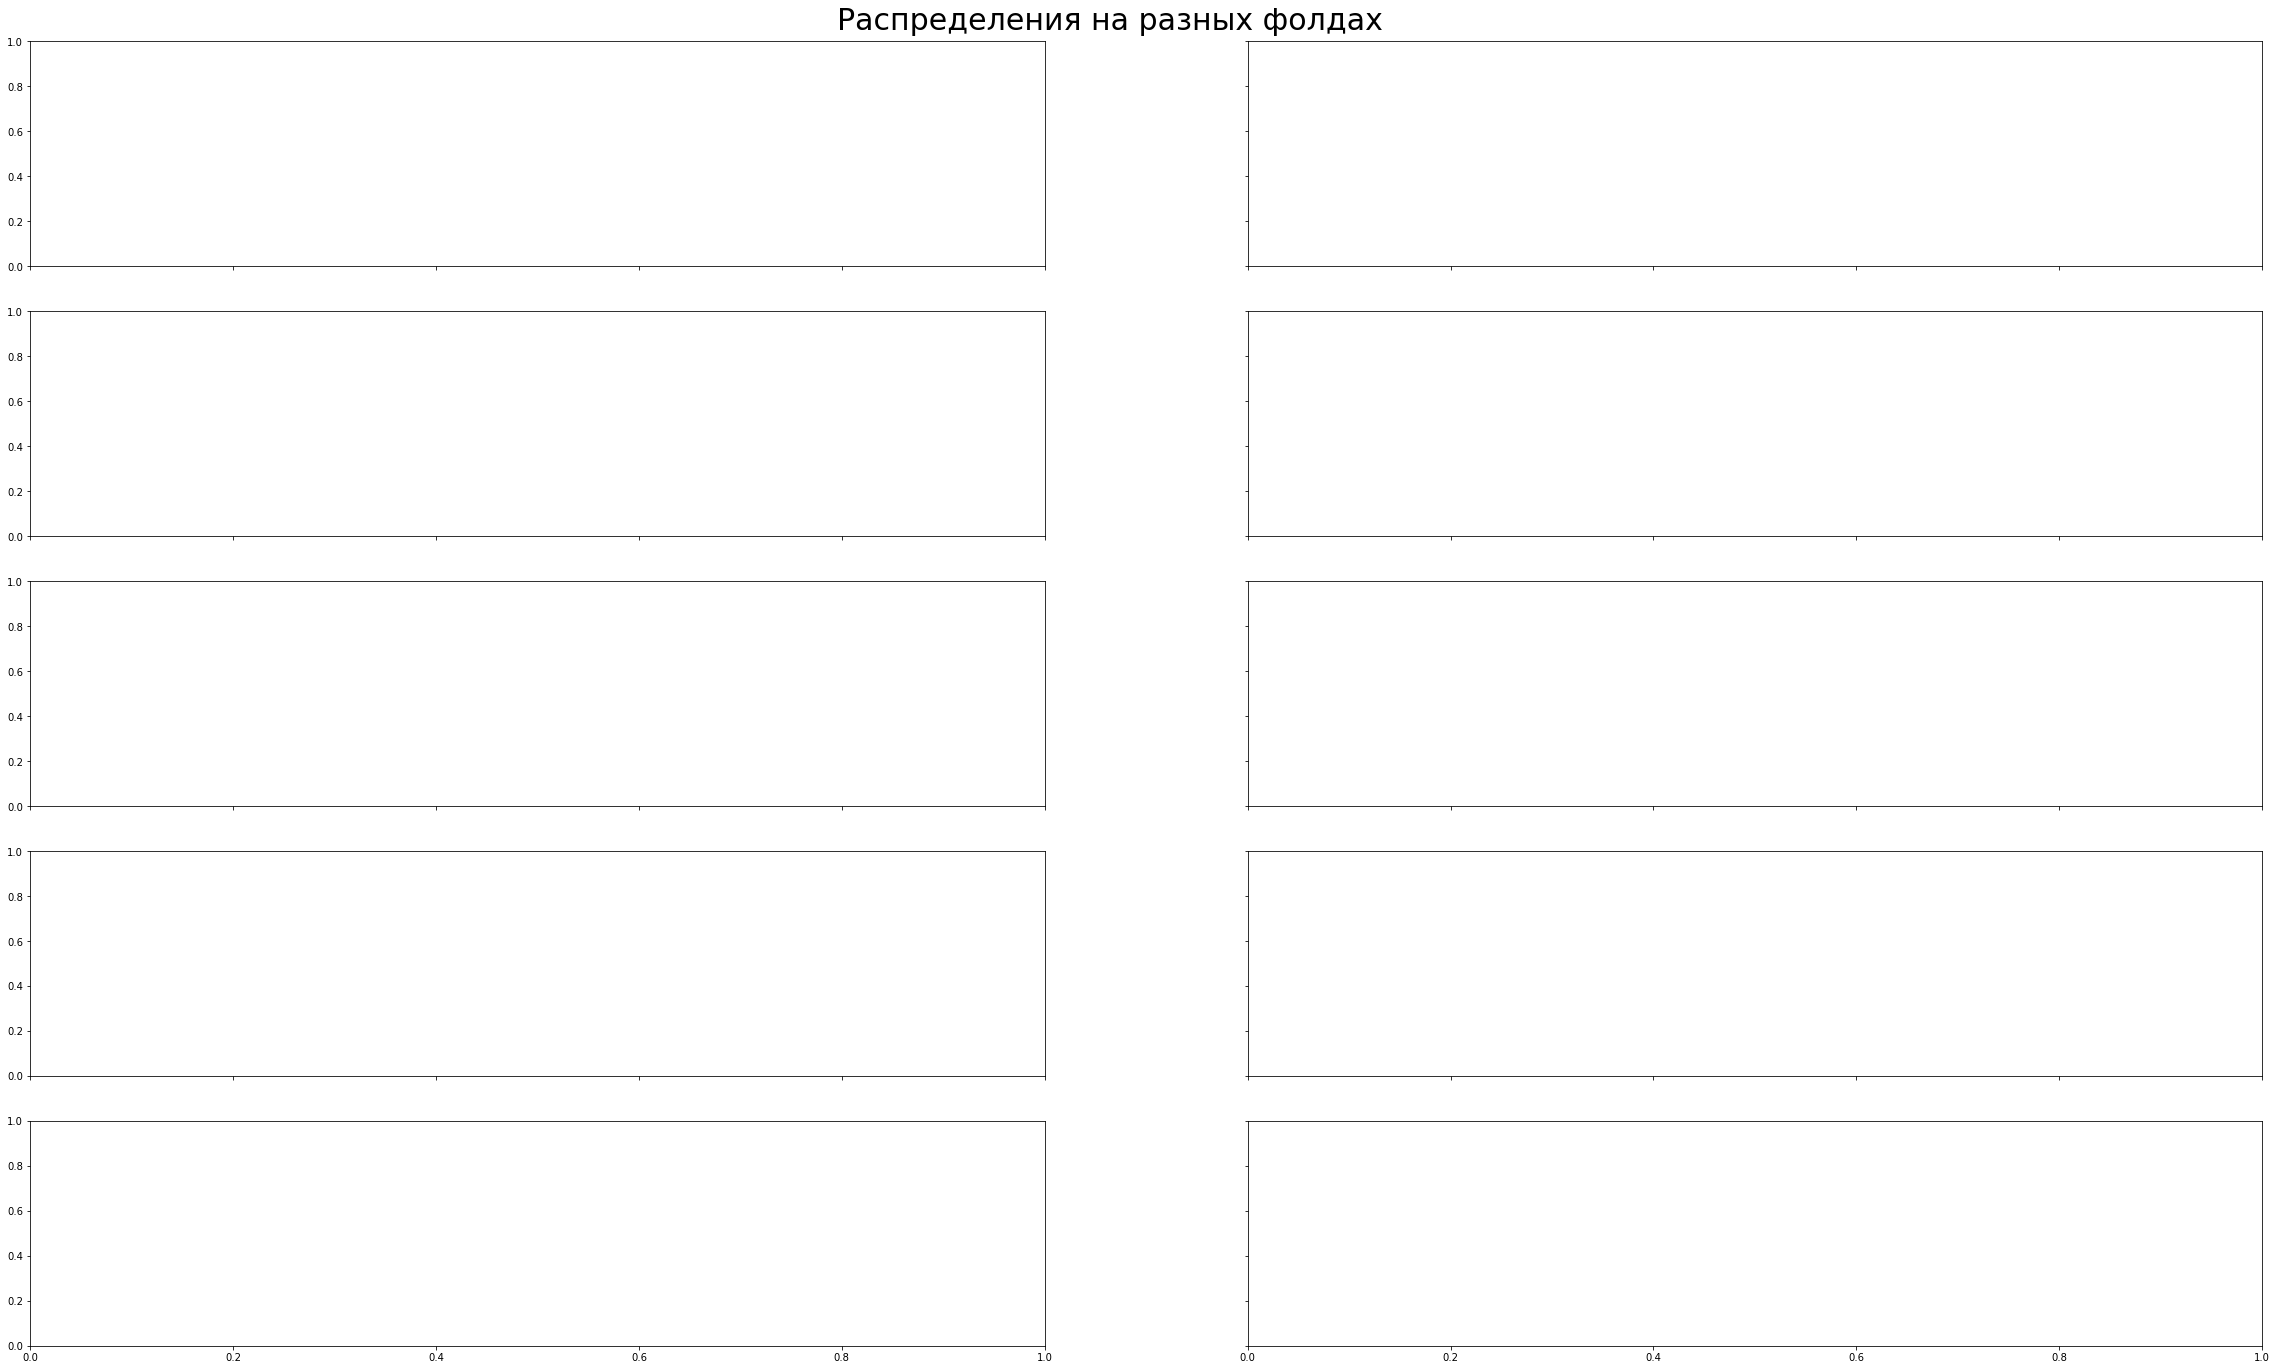

In [215]:
f, axes = plt.subplots(nrows = 5, ncols=2, figsize=(24, 40), sharex=True, sharey = True)
# n_neighbors = 2
f.suptitle(f'Распределения на разных фолдах', y=0.9, fontsize=30)
for i in range(len(feat) // 2):
#     print(i)
    ax = axes[i % 5][i // 5]
#     df1 = df[feat[i * 2 : i * 2 + 2]].dropna()
#     X = df1[[feat[i * 2]]].values
#     y = df1[[feat[i * 2 + 1]]].values
#     reg = KNeighborsRegressor().fit(X, y)
#     knb = reg.kneighbors(X, n_neighbors=n_neighbors, return_distance=False)
#     pred = []
# #     print(X.shape)
#     for j, x in enumerate(X):
#         pred.append(np.mean(y[knb[j][knb[j] != i]]))
# #     print(pred[:10])
#     df1[feat[i * 2 + 1] + '_pred'] = pred
    plotik_ax(df.loc[df['fold'] == 0], feat[i * 2], feat[i * 2 + 1], ax, color='b')    
    plotik_ax(df.loc[df['fold'] == 1], feat[i * 2], feat[i * 2 + 1], ax, color='r')

Посмотрим, как это будет работать, если обучение и тест на разных фолдах

0
1
2
3
4
5
6
7
8
9


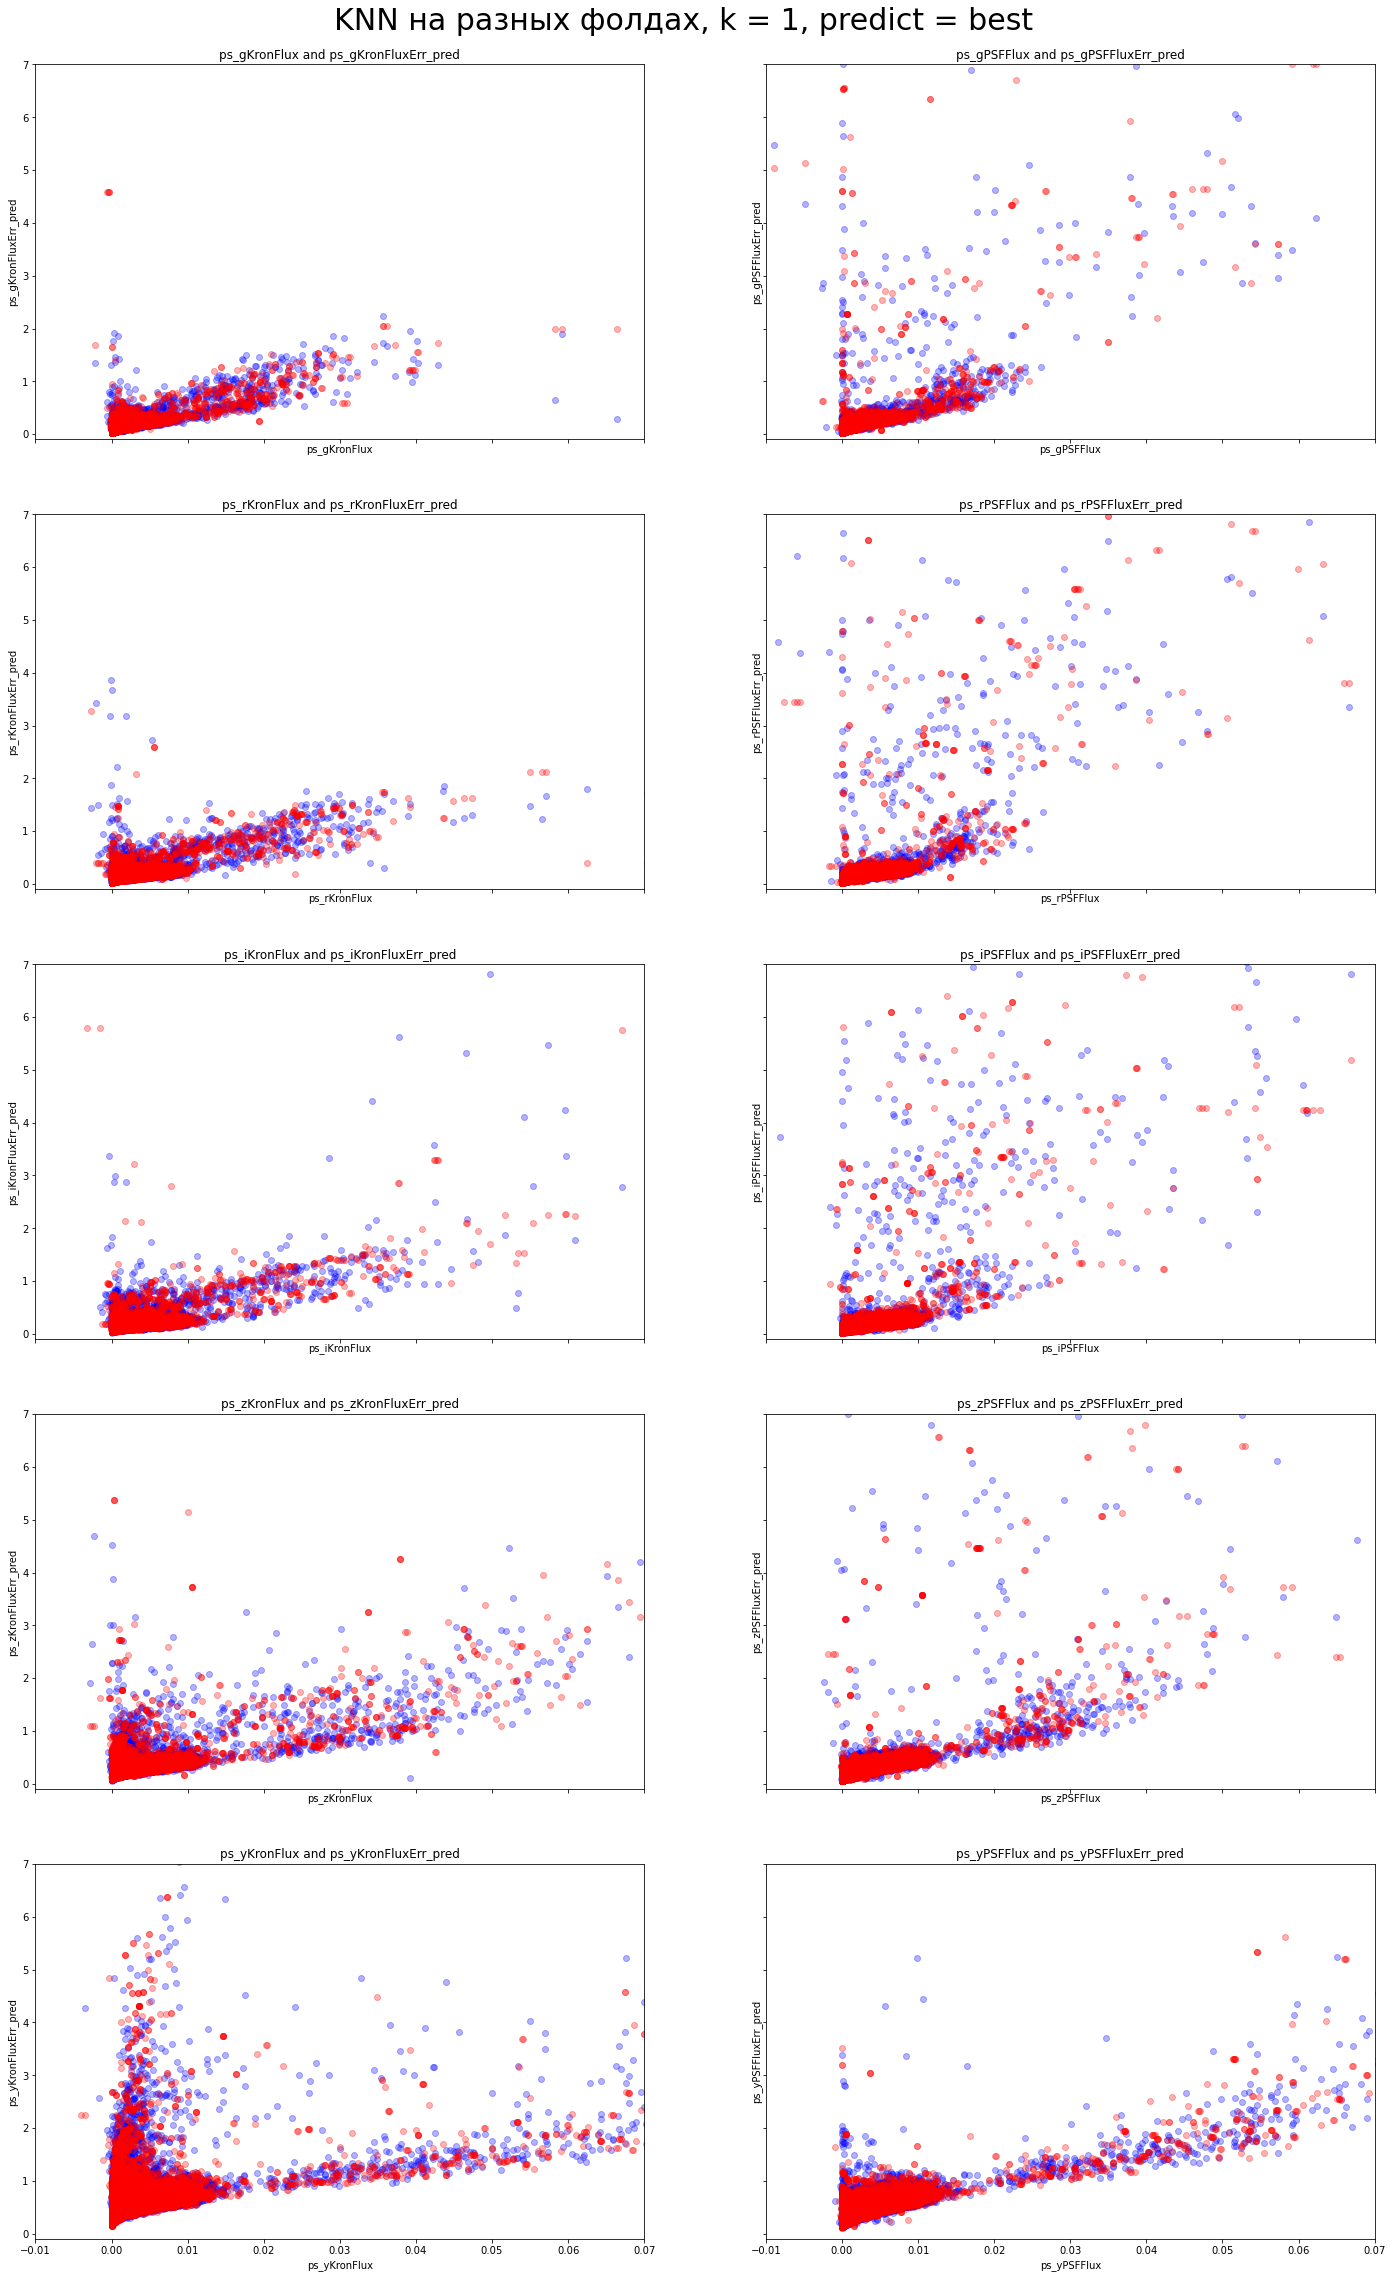

In [220]:
f, axes = plt.subplots(nrows = 5, ncols=2, figsize=(24, 40), sharex=True, sharey = True)
n_neighbors = 2
f.suptitle(f'KNN на разных фолдах, k = {n_neighbors - 1}, predict = best', y=0.9, fontsize=30)
for i in range(len(feat) // 2):
    print(i)
    ax = axes[i % 5][i // 5]
    
    df0 = df.loc[df['fold']==0][feat[i * 2 : i * 2 + 2]].dropna()
    df1 = df.loc[df['fold']==1][feat[i * 2 : i * 2 + 2]].dropna()
    X = df1[[feat[i * 2]]]
    y = df1[[feat[i * 2 + 1]]]
    X_t = df0[[feat[i * 2]]]
    y_t = df0[[feat[i * 2 + 1]]]
    
    reg = KNeighborsRegressor(n_neighbors=n_neighbors-1).fit(X, y)
    df0[feat[i * 2 + 1] + '_pred'] = reg.predict(X_t)
    
    plotik_ax(df0, feat[i * 2], feat[i * 2 + 1], ax, color='b')    
    plotik_ax(df0, feat[i * 2], feat[i * 2 + 1] + '_pred', ax, color='r')

Можно было бы оставить и в таком виде, но если мы будем разыгрывать в дальнейшем также и зачение потока, то имеет смысл расширить просмотр. Это можно сделать следущим образом: 
 * Разыграем результат случайным образом из n ближайших примеров 
 * Разыграем аналогично, но с учетом распределения в тренировочной выборке по оси y (чем оно отличается от пункта выше?)
 * Менять n в зависимоти от величины потока
 * Использовать для первых двух задач случайный лес - позволит напрямую получить распределние
 
 Что нужно будет подбирать, для улучшения: (n, )

0
1
2
3
4
5
6
7
8
9


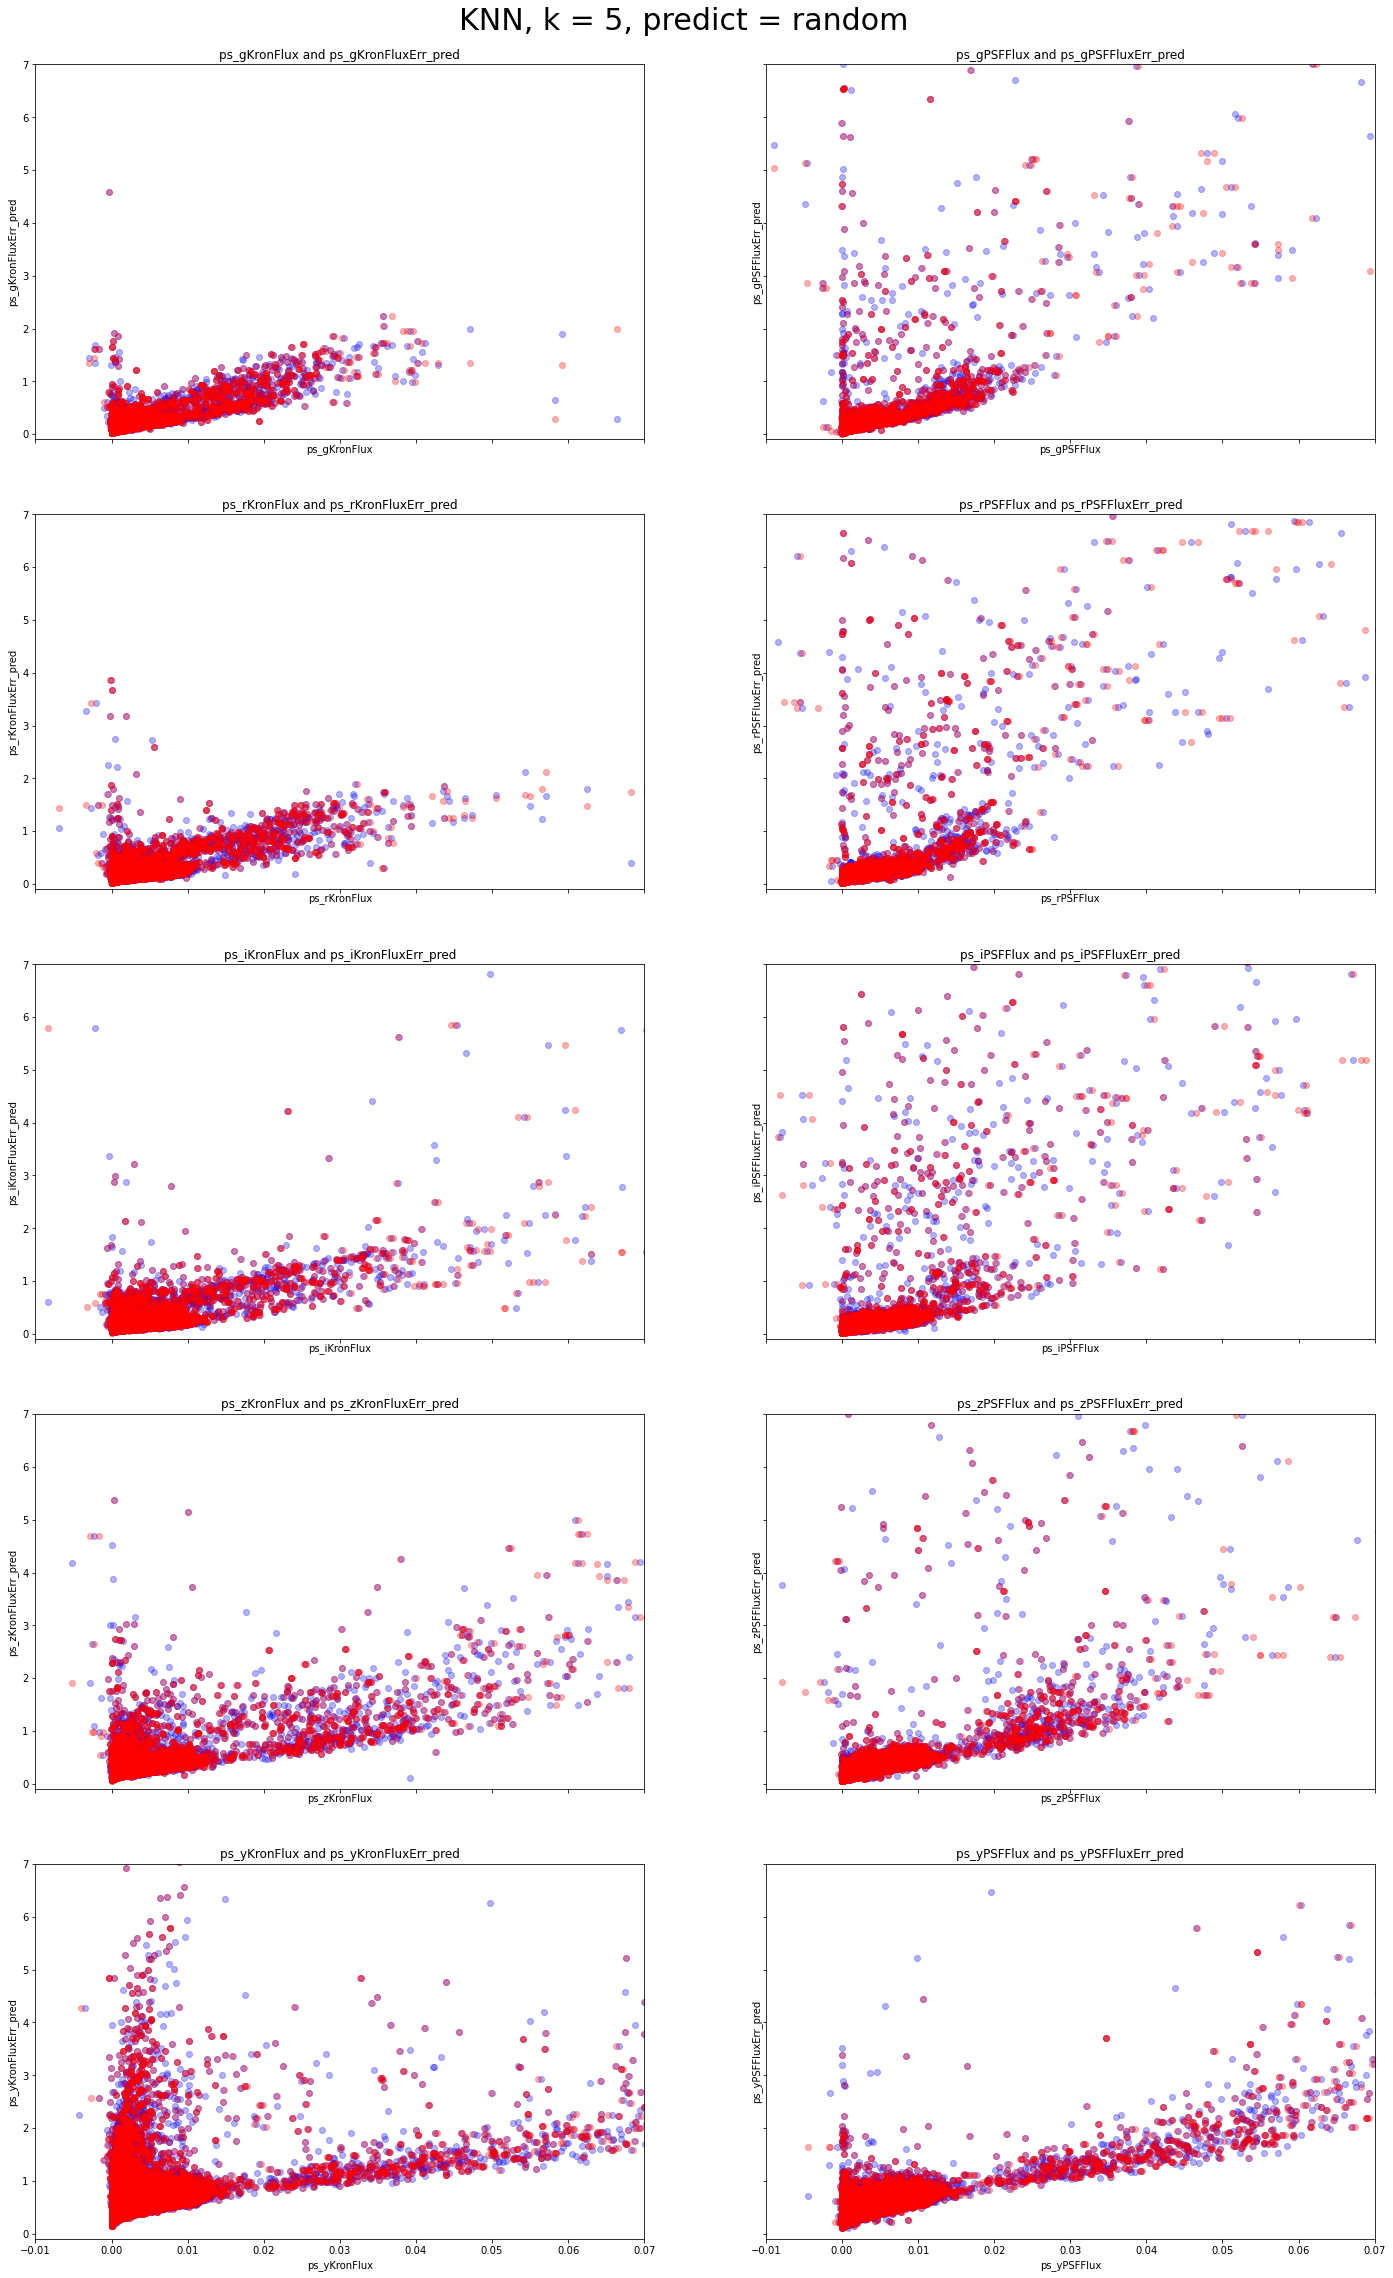

In [255]:
f, axes = plt.subplots(nrows = 5, ncols=2, figsize=(24, 40), sharex=True, sharey = True)
n_neighbors = 5
f.suptitle(f'KNN, k = {n_neighbors}, predict = random', y=0.9, fontsize=30)
for i in range(len(feat) // 2):
    print(i)
    ax = axes[i % 5][i // 5]
    df1 = df[feat[i * 2 : i * 2 + 2]].dropna()
    X = df1[[feat[i * 2]]].values
    y = df1[[feat[i * 2 + 1]]].values
    reg = KNeighborsRegressor().fit(X, y)
    knb = reg.kneighbors(X, n_neighbors=n_neighbors, return_distance=False)
    pred = []
#     print(X.shape)
    for j, x in enumerate(X):
        pred.append(np.random.choice(y[knb[j][knb[j] != j]][:, 0]))
#         print(j, knb[j][knb[j] != j], y[knb[j][knb[j] != j]], pred[:10])
    df1[feat[i * 2 + 1] + '_pred'] = pred
    plotik_ax(df, feat[i*2], feat[i*2 + 1], ax, color='b')    
    plotik_ax(df1, feat[i * 2], feat[i * 2 + 1] + '_pred', ax, color='r')

0
1
2
3
4
5
6
7
8
9


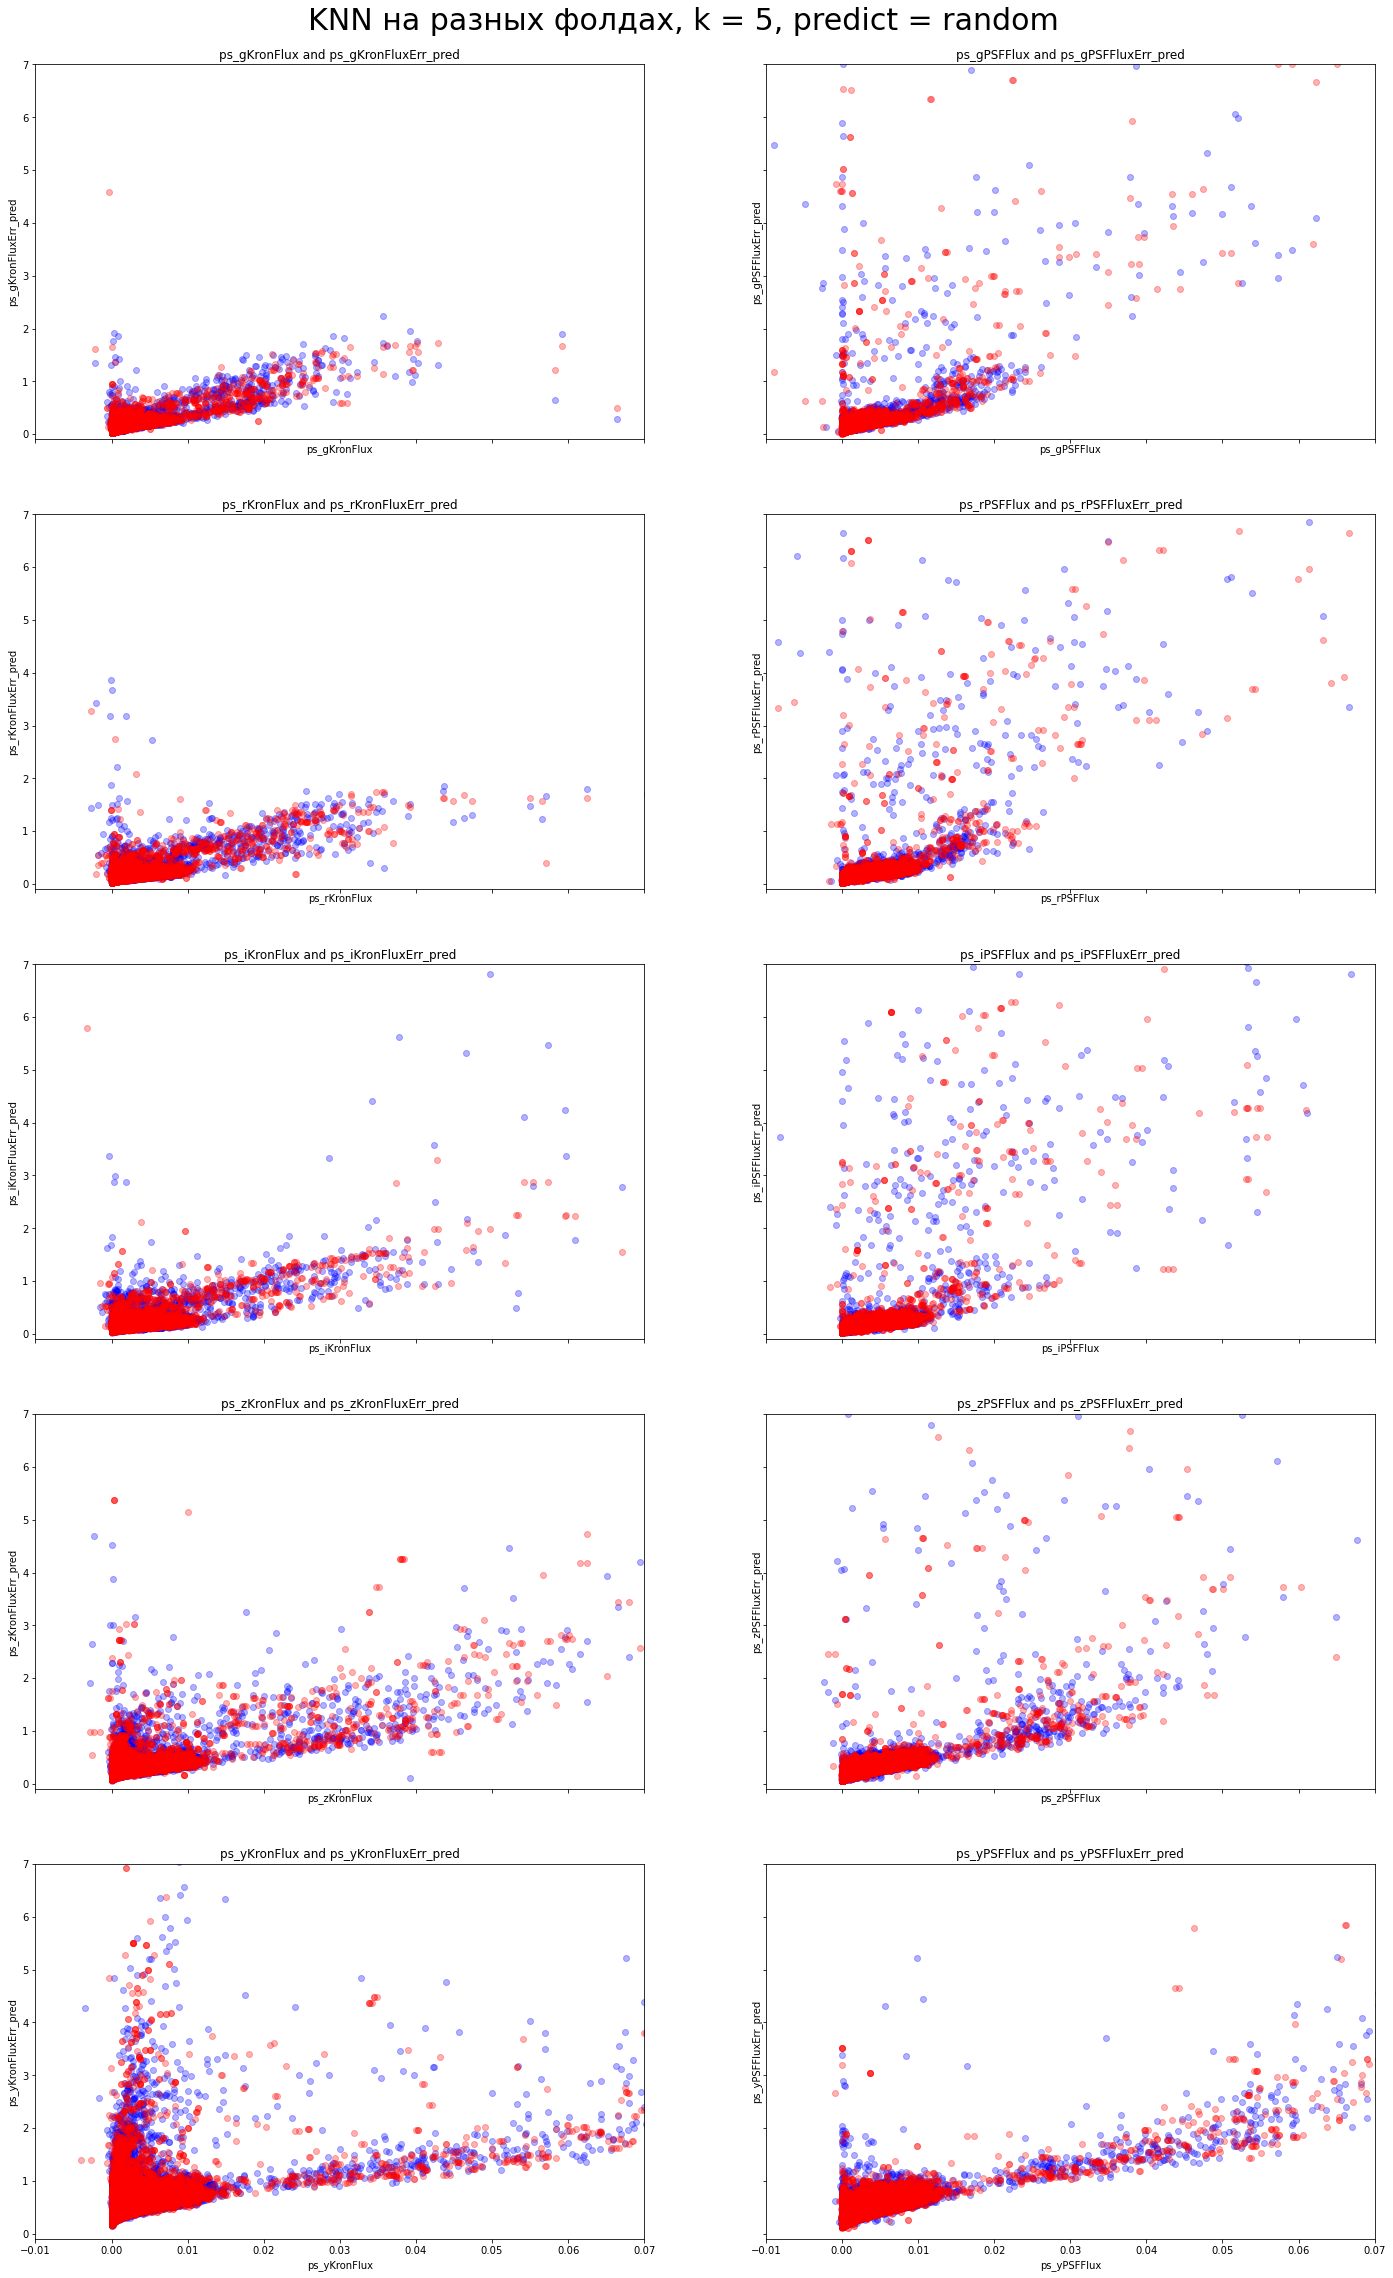

In [256]:
f, axes = plt.subplots(nrows = 5, ncols=2, figsize=(24, 40), sharex=True, sharey = True)
n_neighbors = 5
f.suptitle(f'KNN на разных фолдах, k = {n_neighbors}, predict = random', y=0.9, fontsize=30)
for i in range(len(feat) // 2):
    print(i)
    ax = axes[i % 5][i // 5]
    
    df0 = df.loc[df['fold']==0][feat[i * 2 : i * 2 + 2]].dropna()
    df1 = df.loc[df['fold']==1][feat[i * 2 : i * 2 + 2]].dropna()
    X = df1[[feat[i * 2]]].values
    y = df1[[feat[i * 2 + 1]]].values
    X_t = df0[[feat[i * 2]]].values
    y_t = df0[[feat[i * 2 + 1]]].values
    
    reg = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X, y)
    knb = reg.kneighbors(X_t, n_neighbors=n_neighbors, return_distance=False)
    pred = []
#     print(X.shape)
    for j, x in enumerate(X_t):
        pred.append(np.random.choice(y[knb[j]][:, 0]))
#         print(j, knb[j][knb[j] != j], y[knb[j][knb[j] != j]], pred[:10])
    df0[feat[i * 2 + 1] + '_pred'] = pred
    
    plotik_ax(df0, feat[i * 2], feat[i * 2 + 1], ax, color='b')    
    plotik_ax(df0, feat[i * 2], feat[i * 2 + 1] + '_pred', ax, color='r')

In [252]:
def hist_ax(p, x, y, ax, color='r'):
    ax.set_xlim([-0.01, 0.07])
    ax.hist(p.loc[:, [x]], bins=200)
    return ax

0
1
2
3
4
5
6
7
8
9


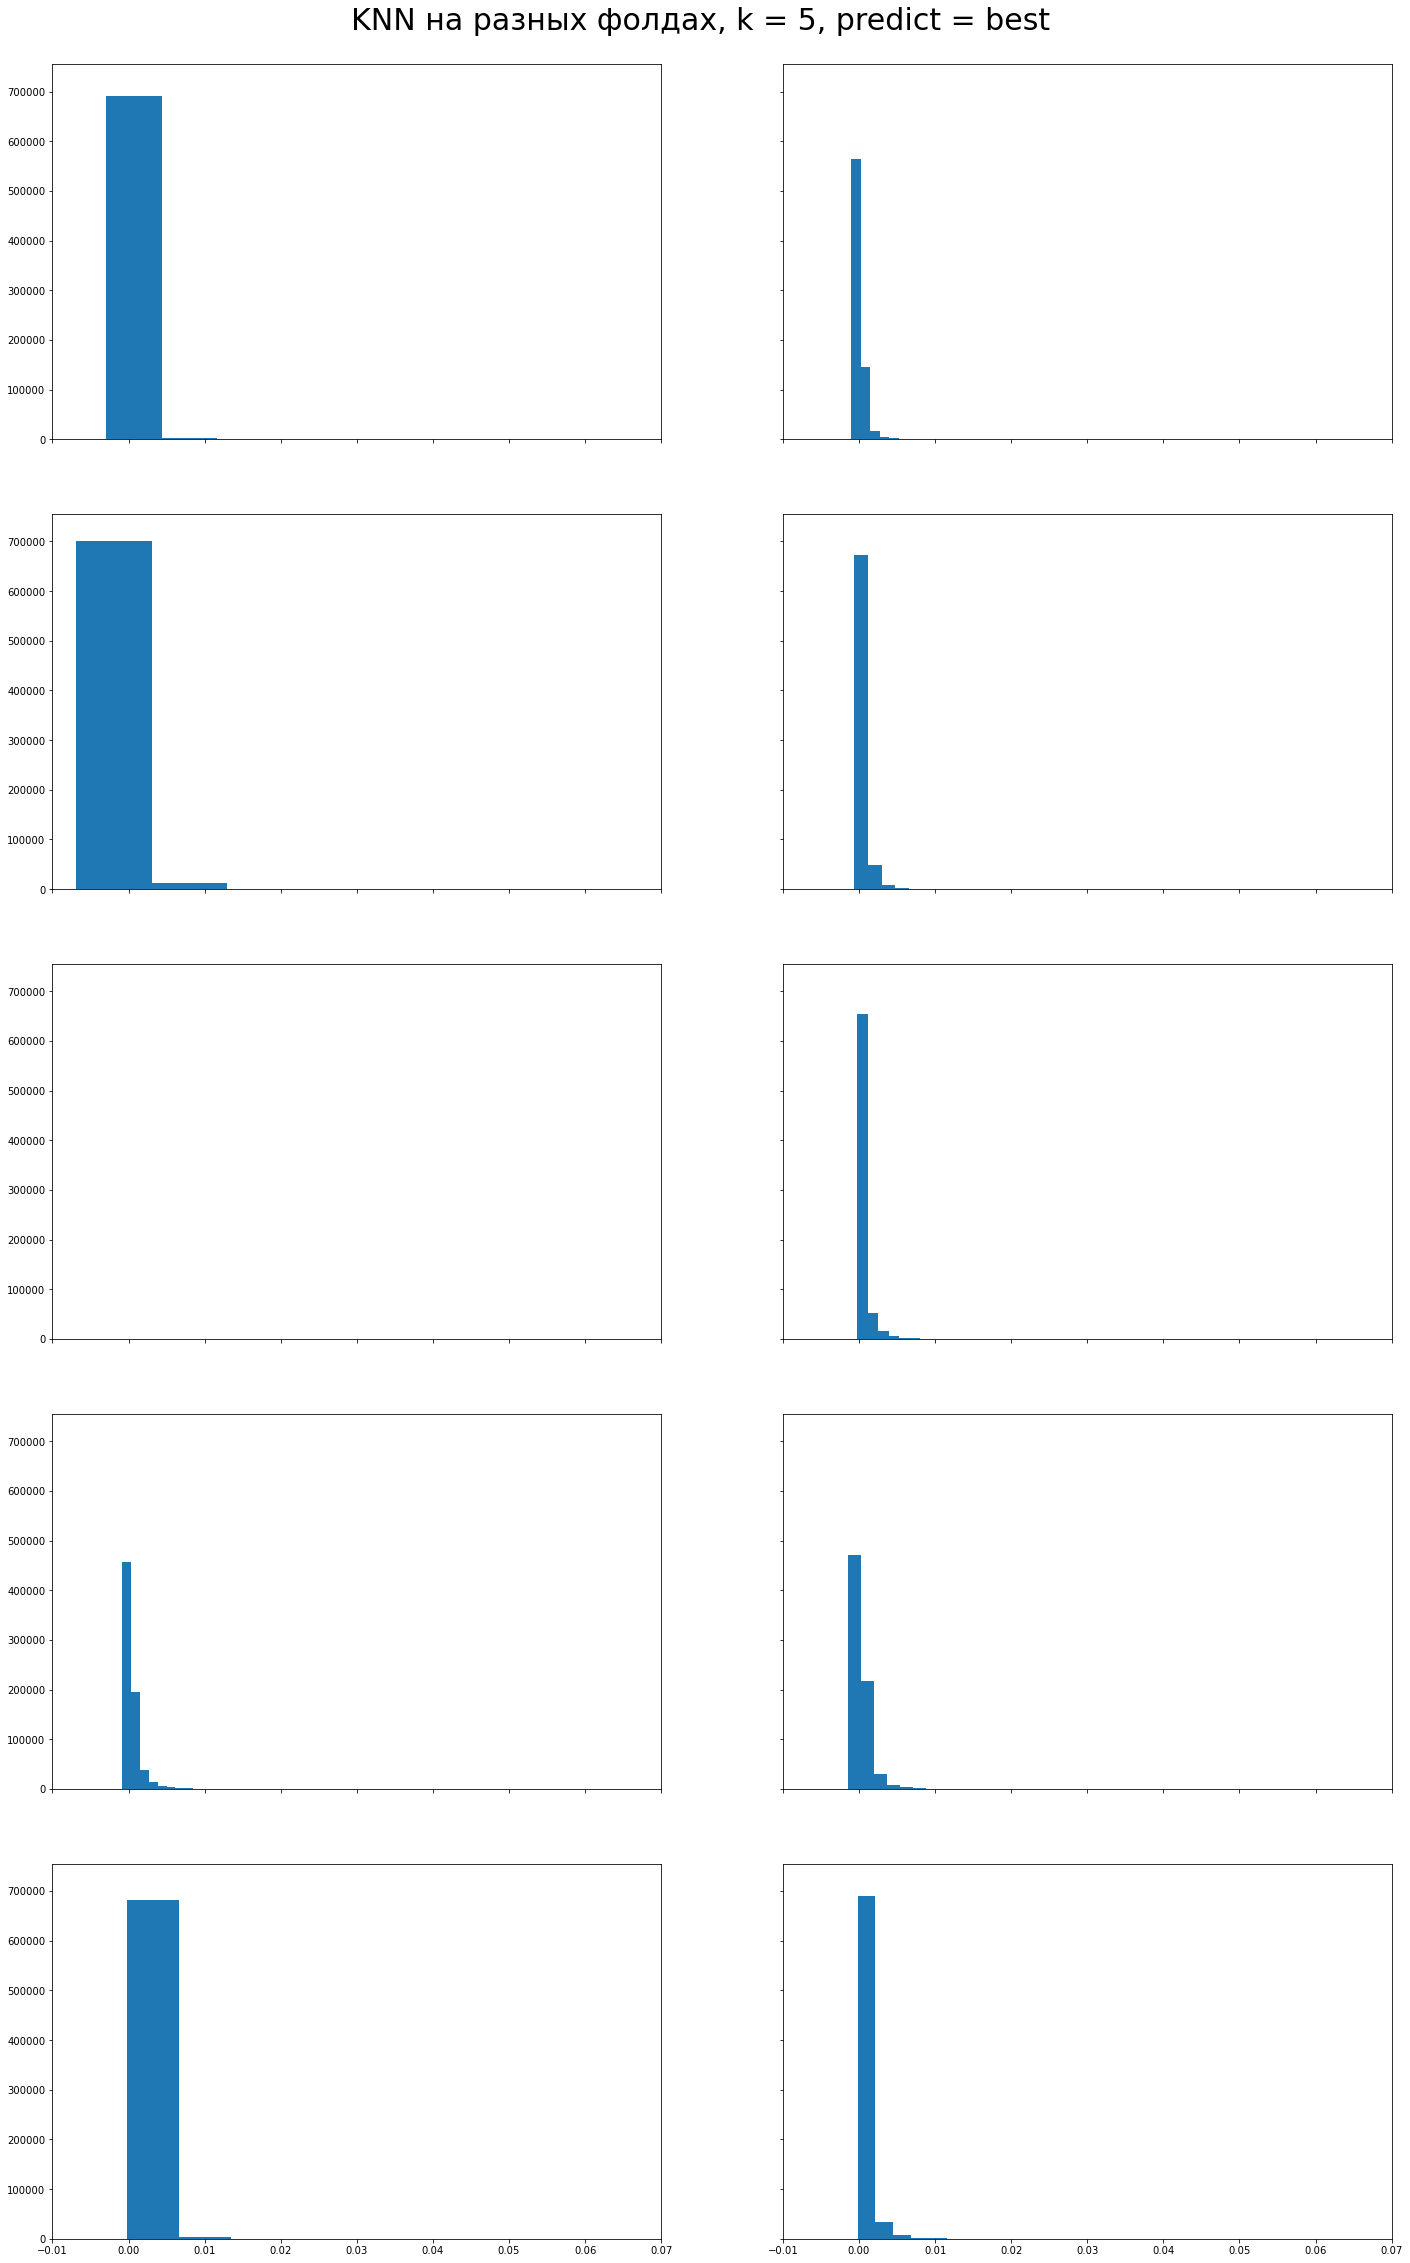

In [254]:
f, axes = plt.subplots(nrows = 5, ncols=2, figsize=(24, 40), sharex=True, sharey = True)
n_neighbors = 5
f.suptitle(f'KNN на разных фолдах, k = {n_neighbors}, predict = best', y=0.9, fontsize=30)
for i in range(len(feat) // 2):
    print(i)
    ax = axes[i % 5][i // 5]
    hist_ax(df, feat[i * 2], feat[i * 2 + 1], ax, color='b')    

Неплохо, но хочется быть более изменчивым относительно плотности объектов. Например, при потоке около 0 больше всего объектов. Попробуем пройти по радиусу

In [ ]:
f, axes = plt.subplots(nrows = 5, ncols=2, figsize=(24, 40), sharex=True, sharey = True)
r = 0.001
f.suptitle(f'RadiusNeighborsRegressor, predict = best', y=0.9, fontsize=30)
for i in range(len(feat) // 2):
#     print(i)
    ax = axes[i % 5][i // 5]
    df1 = df[feat[i * 2 : i * 2 + 2]].dropna()
    X = df1[[feat[i * 2]]].values
    y = df1[[feat[i * 2 + 1]]].values
    reg = KNeighborsRegressor().fit(X, y)
    knb = reg.kneighbors(X, n_neighbors=n_neighbors, return_distance=False)
    pred = []
#     print(X.shape)
    for j, x in enumerate(X):
        pred.append(np.mean(y[knb[j][knb[j] != j]]))
#     print(pred[:10])
    df1[feat[i * 2 + 1] + '_pred'] = pred
    plotik_ax(df, feat[i*2], feat[i*2 + 1], ax, color='b')    
    plotik_ax(df1, feat[i * 2], feat[i * 2 + 1] + '_pred', ax, color='r')

In [ ]:
f, axes = plt.subplots(nrows = 5, ncols=2, figsize=(24, 40), sharex=True, sharey = True)
r = 0.001
f.suptitle(f'RadiusNeighborsRegressor, r = {r}, predict = random', y=0.9, fontsize=30)
for i in range(len(feat) // 2):
    print(i)
    ax = axes[i % 5][i // 5]
    df1 = df[feat[i * 2 : i * 2 + 2]].dropna()
    X = df1[[feat[i * 2]]].values
    y = df1[[feat[i * 2 + 1]]].values
    reg = RadiusNeighborsRegressor(radius=r).fit(X, y)
    rnb = reg.radius_neighbors(X, radius=r, return_distance=False)
    pred = []
    print(X.shape)
    for j, x in enumerate(X):
        pred.append(np.random.choice(y[rnb[j][rnb[j] != j]][:, 0]))
#         print(j, knb[j][knb[j] != j], y[knb[j][knb[j] != j]], pred[:10])
    df1[feat[i * 2 + 1] + '_pred'] = pred
    plotik_ax(df, feat[i*2], feat[i*2 + 1], ax, color='b')    
    plotik_ax(df1, feat[i * 2], feat[i * 2 + 1] + '_pred', ax, color='r')

0


Разыгрывание величин:

In [112]:
import random
def add_err(inputs):
#     print(inputs)
    flux, err = inputs
    mu = flux
    sigma = err
    return random.gauss(mu, sigma)

In [113]:
def plotik_ax(p, x, y, ax, color='r'):
    ax.set_title(x + ' and ' + y)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_xlim([-0.01, 0.07])
    ax.set_ylim([-0.1, 7])
    ax.scatter(p.loc[:, [x]], p.loc[:, [y]] / 0.00001, c=color, alpha=0.3)
    return ax

In [118]:
def plotik_err_ax(p, x, y, ax, color='r'):
    ax.set_title(x + ' and ' + y)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_xlim([-0.01, 0.07])
    ax.set_ylim([-0.1, 7])
    print(p.loc[0, [x, y]], p.loc[0, [x, y]].apply(add_err, axis=1))
    ax.scatter(p.loc[:, [x, y]].apply(add_err, axis=1), p.loc[:, [y]] / 0.00001, c=color, alpha=0.3)
    return ax

0
   ps_gKronFlux  ps_gKronFluxErr
0      0.000050     5.087760e-07
0      0.000086     5.777570e-07
0      0.000541     1.082540e-06
0      0.000158     6.902280e-07
0      0.000027     4.837880e-07
0      0.000060     6.629000e-07
0      0.000216     9.289720e-07 0    0.000050
0    0.000085
0    0.000540
0    0.000158
0    0.000026
0    0.000061
0    0.000217
dtype: float64
1
   ps_rKronFlux  ps_rKronFluxErr
0      0.000064     6.686770e-07
0      0.000129     7.419180e-07
0      0.000877     1.292930e-06
0      0.000223     6.604480e-07
0      0.000033     6.515860e-07
0      0.000084     5.935310e-07
0      0.000299     8.943760e-07 0    0.000064
0    0.000128
0    0.000875
0    0.000223
0    0.000034
0    0.000085
0    0.000300
dtype: float64


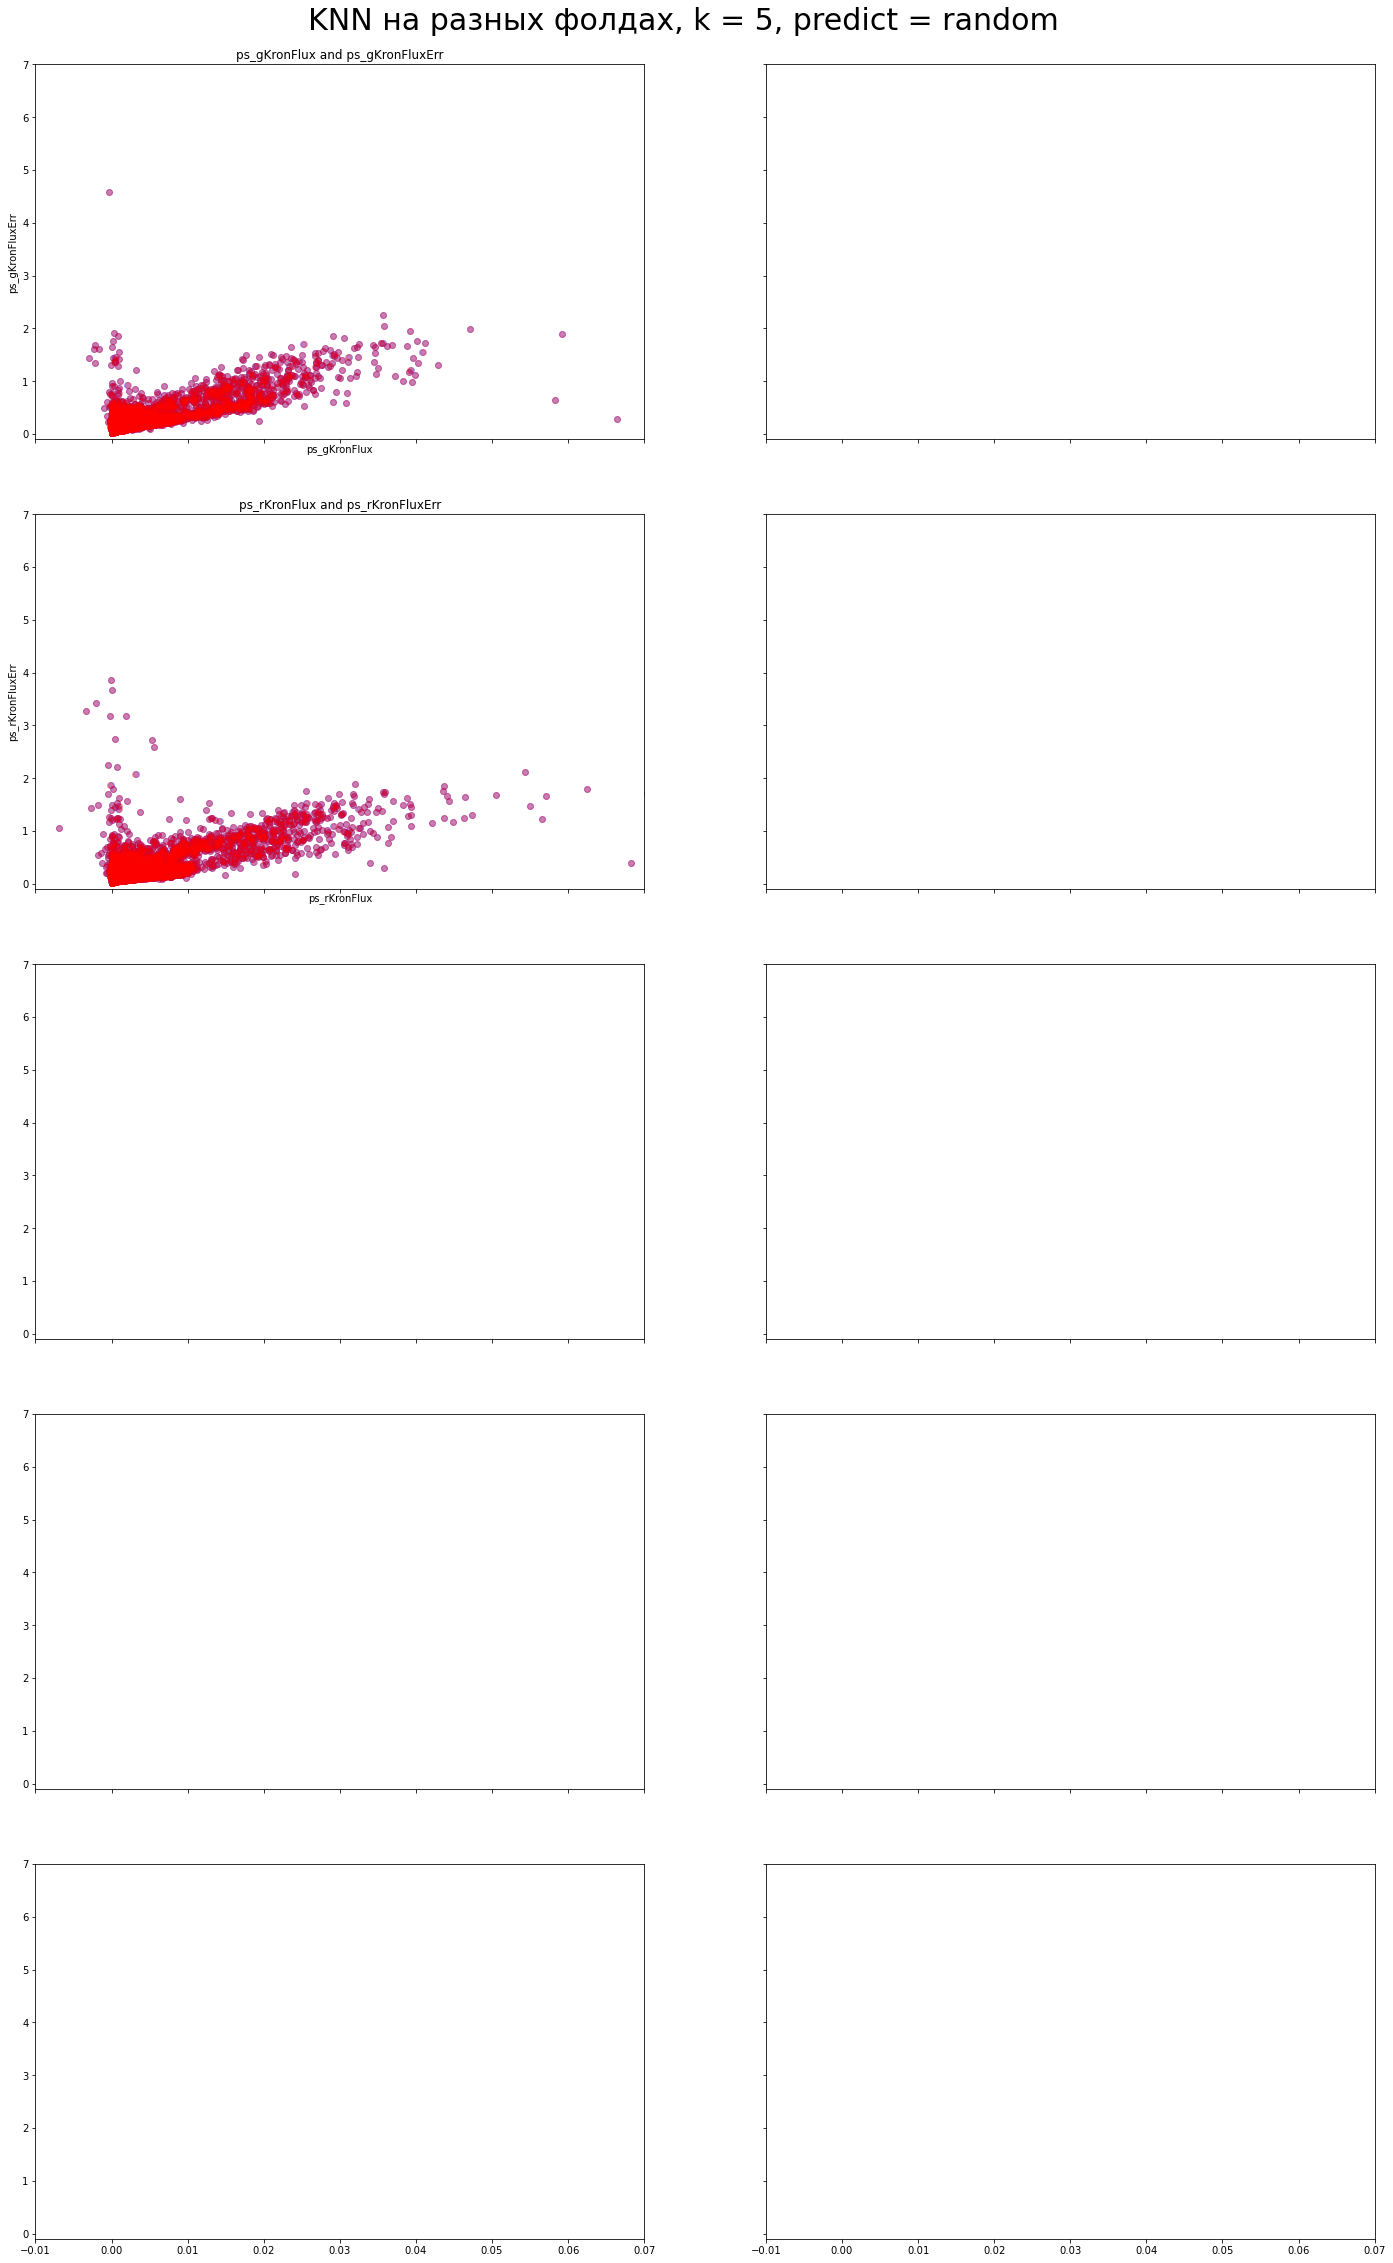

In [119]:
f, axes = plt.subplots(nrows = 5, ncols=2, figsize=(24, 40), sharex=True, sharey = True)
n_neighbors = 5
f.suptitle(f'KNN на разных фолдах, k = {n_neighbors}, predict = random', y=0.9, fontsize=30)
for i in range(2):
    ax = axes[i % 5][i // 5]
    print(i)
    df1 = df.loc[:, feat[i * 2 : i * 2 + 2]].dropna()
    plotik_ax(df1, feat[i * 2], feat[i * 2 + 1], ax, color='b')    
    plotik_err_ax(df1, feat[i * 2], feat[i * 2 + 1], ax, color='r')

In [ ]:
def asinhmag_dm(flux, flux_err=None, flux_ivar=None, dm=0):
    """
    Calculate asinh mognitude with dm shift.
    ::flux      - flux in [nanomaggies]
    ::flux_ivar - inverse variance of flux in [1/nanomaggies**2]
    ::flux_err  - flux error in [nanomaggies]
    ::dm        - magnitude shift
    """
    assert (flux_err is not None) ^ (
                flux_ivar is not None), 'specify only flux_err or flux_ivar'
    f = flux / 1e9 * np.power(10, 0.4 * dm)
    if flux_ivar is not None:
        b = np.power(flux_ivar, -0.5) / 1e9 * np.power(10, 0.4 * dm)
    else:
        pred_flux_err = 
        b = flux_err / 1e9 * np.power(10, 0.4 * dm)

    f, b = f.astype(np.float64), b.astype(
        np.float64)  # otherwise type error like
    # TypeError: loop of ufunc does not support argument 0 of type numpy.float64 which has no callable arcsinh method

    return (np.arcsinh(f / (2 * b)) + np.log(b)) * (-2.5 / np.log(10))

In [122]:
df[feat[:2] + ['psdr2_g_kron']]

,ps_gKronFlux,ps_gKronFluxErr,psdr2_g_kron
0,NaN,NaN,17.736503
1,NaN,NaN,14.639986
5,NaN,NaN,17.409018
6,NaN,NaN,15.829256
11,NaN,NaN,17.723120
...,...,...,...
60414,0.000019,4.157550e-07,20.696908
60415,0.000006,4.061050e-07,22.023210
60416,NaN,NaN,23.589236
60417,0.000015,6.463960e-07,20.923506


In [ ]:
df.loc[60415]